# Выпускной проект. A/B-тестирование

## Краткое описание проекта
Проведение анализа результатов A/B-тестирования изменений, связанных с внедрением улучшенной рекомендательной системы интернет-магазина.

### Описание данных

- `ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год
    - `name` — название маркетингового события
    - `regions` — регионы, в которых будет проводиться рекламная кампания
    - `start_dt` — дата начала кампании
    - `finish_dt` — дата завершения кампании
    
    
- `final_ab_new_users.csv` — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года
    - `user_id` — идентификатор пользователя
    - `first_date` — дата регистрации
    - `region` — регион пользователя
    - `device` — устройство, с которого происходила регистрация
    
    
- `final_ab_events.csv` — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
    - `user_id` — идентификатор пользователя
    - `event_dt` — дата и время события
    - `event_name` — тип события
    - `details` — дополнительные данные о событии (например, сумма покупки в долларах)
    

- `final_ab_participants.csv` — таблица участников тестов
    - `user_id` — идентификатор пользователя
    - `ab_test` — название теста
    - `group` — группа пользователя

### Задача
Проведение оценки результатов A/B-теста и корректности его проведения.

### Техническое задание
- Название теста: recommender_system_test
- Группы: А (контрольная), B (новая платёжная воронка)
- Дата запуска: 2020-12-07
- Дата остановки набора новых пользователей: 2020-12-21
- Дата остановки: 2021-01-04
- Ожидаемое количество участников теста: 15% новых пользователей из региона EU
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 5 процентных пунктов:
    - конверсии в просмотр карточек товаров — событие product_page
    - просмотры корзины — product_cart
    - покупки — purchase

## Загрузка данных

### Импорт необходимых библиотек

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

# визуализация
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import seaborn as sns

# проверка статистических гипотез
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

### Загрузка данных

In [2]:
links = ['ab_project_marketing_events.csv',
         'final_ab_new_users.csv',
         'final_ab_events.csv',
         'final_ab_participants.csv']

dfs = []
for link in links:
    dfs.append(pd.read_csv(link))
    
marketing_events = dfs[0]
new_users = dfs[1]
events = dfs[2]
participants = dfs[3]

### Определение вспомогательных функций

In [3]:
# функция для выведения первых строк таблицы, общей информации, количества пропусков и дубликатов

def df_info(df):
    print(df.head(), '\n')
    print(df.info(), '\n')
    print(f"Полных дубликатов в таблице: {df.duplicated().sum()}")
    print(f"Пропусков в таблице: {df.isna().sum().sum()}")

In [4]:
# функция для выведения уникальных типов данных в столбце таблицы

def types(column):
    types = []
    for i in column:
        types.append(type(i))
    return set(types)

## Ознакомление с данными

### Таблица `marketing_events`

#### Общая информация о таблице

In [5]:
df_info(marketing_events)

                           name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes
None 

Полных дубликатов в таблице: 0
Пропусков в таблице: 0


**Выводы по таблице**

- таблица содержит данные о 14 маркетинговых событиях
- пропусков и полных дубликатов нет
- столбцы `start_dt` и `finish_dt` содержат данные типа `object`:
    - необходимо проверить, что это за типы, и при необходимости изменить тип данных
- данные в столбце `regions` не нормализованы, так как одному событию соответствуют несколько регионов:
    - необходимо выделить отдельный столбец с признаком проведения кампании в целевом регионе (EU)

#### Анализ необходимости изменения типов данных

Столбцы с типом данных `object` могут содержать как строковые данные, так и смешанные числовые и нечисловые данные. Также некоторые временные типы могут отображаться с этим типом данных. Для определения необходимости преобразования данных в столбцах `start_dt` и `finish_dt` и выбора соответствующего метода определим, какие именно данные содержатся в столбцах.

In [6]:
for column in ['start_dt', 'finish_dt']:
    print(column)
    print(types(marketing_events[column]), '\n')

start_dt
{<class 'str'>} 

finish_dt
{<class 'str'>} 



Все данные в столбцах `start_dt` и `finish_dt` - строковые. Необходимо будет привести данные к формату `datetime`.

#### Добавление столбца с признаком проведения кампании в регионе EU

In [7]:
marketing_events['EU'] = marketing_events['regions'].apply(lambda x: 1 if 'EU' in x else 0)
marketing_events

name                   regions    start_dt  \
0           Christmas&New Year Promo             EU, N.America  2020-12-25   
1       St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2             St. Patric's Day Promo             EU, N.America  2020-03-17   
3                       Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4                  4th of July Promo                 N.America  2020-07-04   
5          Black Friday Ads Campaign  EU, CIS, APAC, N.America  2020-11-26   
6             Chinese New Year Promo                      APAC  2020-01-25   
7   Labor day (May 1st) Ads Campaign             EU, CIS, APAC  2020-05-01   
8    International Women's Day Promo             EU, CIS, APAC  2020-03-08   
9    Victory Day CIS (May 9th) Event                       CIS  2020-05-09   
10         CIS New Year Gift Lottery                       CIS  2020-12-30   
11     Dragon Boat Festival Giveaway                      APAC  2020-06-25   
12           Single's Day Gift Promo                      APAC  2020-11-11   
13             Chinese Moon Festival                      APAC  2020-10-01   

     finish_dt  EU  
0   2021-01-03   1  
1   2020-02-16   1  
2   2020-03-19   1  
3   2020-04-19   1  
4   2020-07-11   0  
5   2020-12-01   1  
6   2020-02-07   0  
7   2020-05-03   1  
8   2020-03-10   1  
9   2020-05-11   0  
10  2021-01-07   0  
11  2020-07-01   0  
12  2020-11-12   0  
13  2020-10-07   0

### Таблица `new_users`

#### Общая информация о таблице

In [8]:
df_info(new_users)

            user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None 

Полных дубликатов в таблице: 0
Пропусков в таблице: 0


**Выводы по таблице**

- таблица содержит данные о 61733 новых пользователях
- пропусков и полных дубликатов нет
- столбец `first_date` содержит данные типа `object`:
    - необходимо проверить, что это за типы, и при необходимости изменить тип данных
- необходимо проверить таблицу на наличие неявных дубликатов (проверить уникальность идентификаторов пользователя)
- требуется изучить распределение данных в столбцах `first_date`, `region` и `device`

#### Анализ необходимости изменения типов данных

In [9]:
types(new_users['first_date'])

{str}

Все данные в столбце - строковые. Необходимо будет привести данные к формату `datetime`.

#### Поиск и анализ неявных дубликатов

In [10]:
# считаем количество уникальных идентификаторов пользователей
new_users['user_id'].nunique()

61733

Количество уникальных идентификаторов совпадает с количеством записей в таблице. Неявных дубликатов нет.

#### Изучение распределения данных

In [11]:
# изучение временных рамок
print(f"Самая ранняя дата регистрации: {str(new_users['first_date'].min())}.")
print(f"Самая поздняя дата регистрации: {str(new_users['first_date'].max())}.")

Самая ранняя дата регистрации: 2020-12-07.
Самая поздняя дата регистрации: 2020-12-23.


Самая раняя дата совпадает с датой запуска теста, а самая поздняя дата выходит за правую границу периода набора новых пользователей. Необходимо провести срез данных по требуемой дате (21.12.2020).

In [12]:
fig = px.bar(new_users.groupby('region').agg({'user_id':'count'}).reset_index().sort_values(by='user_id', ascending=False), x='region', y='user_id', text='user_id', labels={'user_id':'Количество пользователей', 'region':'Регион'}, title='Распределение новых пользователей по регионам')
fig.show()

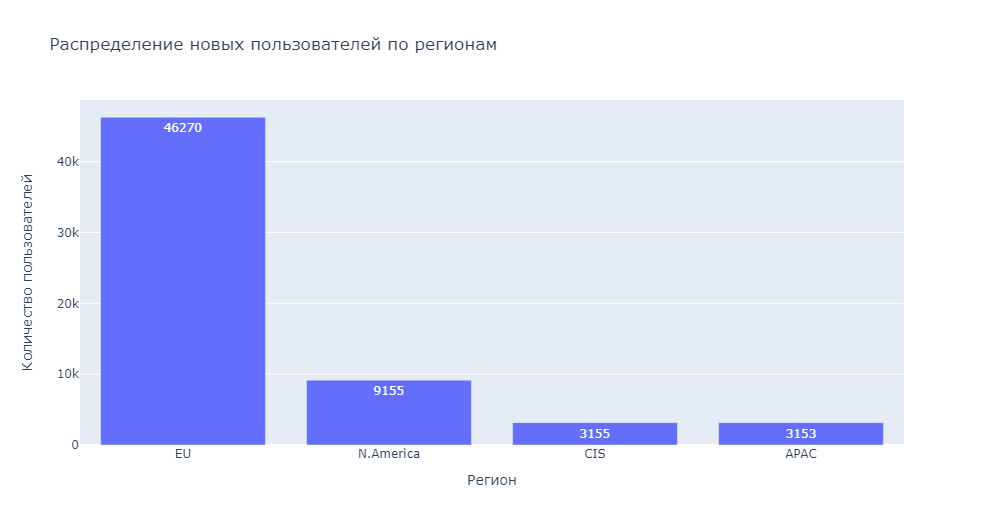

В таблице представлены данные о новых пользователях из 4 регионов. Большая часть пользователей - из целевого региона EU.

In [13]:
fig = px.bar(new_users.groupby('device').agg({'user_id':'count'}).reset_index().sort_values(by='user_id', ascending=False), x='device', y='user_id', text='user_id', labels={'user_id':'Количество пользователей', 'device':'Устройство'}, title='Распределение новых пользователей по устройствам')
fig.show()

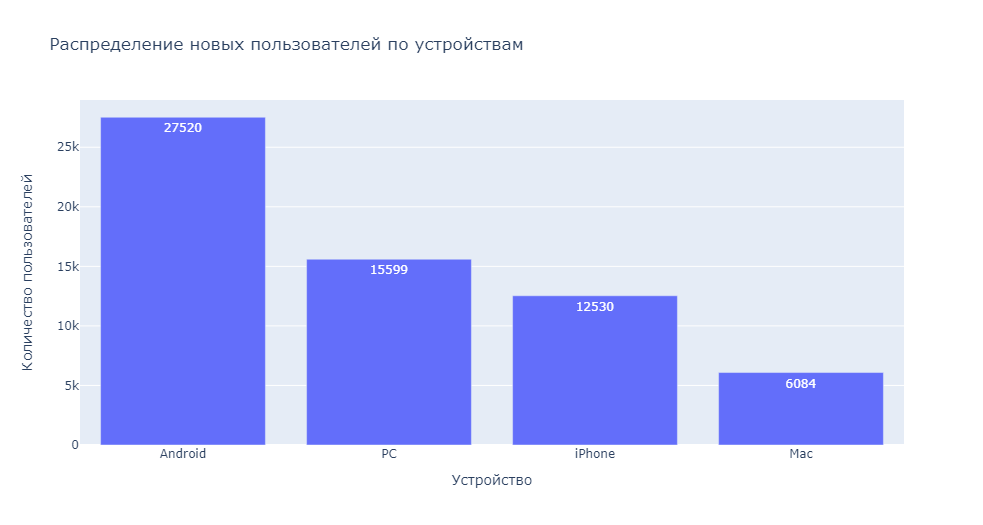

В таблице представлены данные о 4 типах используемых устройств (2 мобильных и 2 стационарных). Чаще всего пользователи регистрируются с помощью устройств Android.

### Таблица `events`

#### Общая информация о таблице

In [14]:
df_info(events)

            user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457  2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None 

Полных дубликатов в таблице: 0
Пропусков в таблице: 377577


In [15]:
print('Количество уникальных пользователей в таблице:', events['user_id'].nunique(), '\n')
print(f"Самая раннее время события: {str(events['event_dt'].min())}")
print(f"Самая позднее время события: {str(events['event_dt'].max())}\n")
print(f"Доля пропусков в столбце details: {round(100*len(events[events['details'].isna()])/len(events))}%")

Количество уникальных пользователей в таблице: 58703 

Самая раннее время события: 2020-12-07 00:00:33
Самая позднее время события: 2020-12-30 23:36:33

Доля пропусков в столбце details: 86%


**Выводы по таблице**

- таблица содержит данные о 440317 событиях, совершенных 58703 пользователями за период с 07.12.2020 по 30.12.2020
- полных дубликатов нет
- столбец `details` содержит 377577 (86%) пропусков
- столбец `event_date` содержит данные типа `object`:
    - необходимо проверить, что это за типы, и при необходимости изменить тип данных
- необходимо проверить таблицу на наличие неявных дубликатов (проверить уникальность временных отметок)
- требуется изучить распределение данных в столбцах `event_name` и `details`

#### Анализ необходимости изменения типов данных

In [16]:
types(events['event_dt'])

{str}

Все данные в столбце - строковые. Необходимо будет привести данные к формату `datetime`.

#### Поиск и анализ неявных дубликатов

In [17]:
# подсчет количества кникальных временных отметок
events['event_dt'].nunique()

267268

Количество уникальных временных отметок значительно меньше, чем общее количество событий - в таблице есть неявные дубликаты.

Такие дубликаты могут быть как минимум двух типов:
- для всех событий пользователя, совершенных в рамках одной сессии, в логе проставлена одна временная отметка 
- несколько пользователей совершили события одновременно

In [18]:
# выделяем все временные отметки, попавшие в таблицу больше 1 раза
duplicates = events.groupby('event_dt').agg(users=('user_id','count')).query('users > 1')

In [19]:
print('Количество повторяющихся временных отметок:', len(duplicates))

Количество повторяющихся временных отметок: 120353


In [20]:
# выделяем временные отметки, события в которых совершал один и тот же пользователь
same_user = events.groupby('event_dt').agg(users=('user_id','count'), unique_users=('user_id','nunique')).query('users > 1 and unique_users == 1')

In [21]:
print('Количество повторяющихся временных отметок:', len(same_user))

Количество повторяющихся временных отметок: 99779


In [22]:
# выводим данные о пользователях с одинаковыми временными отметками для разных событий
events.query('event_dt in @same_user.index').sort_values('event_dt')

user_id             event_dt    event_name  details
253051  EB2D1E4A76B38E24  2020-12-07 00:00:33         login      NaN
756     EB2D1E4A76B38E24  2020-12-07 00:00:33      purchase     9.99
252932  821D82C2BB74CBB2  2020-12-07 00:00:35         login      NaN
126630  821D82C2BB74CBB2  2020-12-07 00:00:35  product_page      NaN
255244  E4BF0599D6E802CA  2020-12-07 00:02:46         login      NaN
...                  ...                  ...           ...      ...
250744  114953E781C03385  2020-12-30 19:45:10  product_page      NaN
440290  F9452D9C3B463498  2020-12-30 20:41:37         login      NaN
62729   F9452D9C3B463498  2020-12-30 20:41:37      purchase     4.99
440298  CE065914C815ADF6  2020-12-30 23:02:44         login      NaN
62732   CE065914C815ADF6  2020-12-30 23:02:44      purchase     9.99

[228769 rows x 4 columns]

In [23]:
print('Количество уникальных пользователей с одинаковыми временными отметками для разных событий:', events.query('event_dt in @same_user.index').sort_values('event_dt')['user_id'].nunique())

Количество уникальных пользователей с одинаковыми временными отметками для разных событий: 42781


Таким образом, у 42781 пользователя в таблице для разных событий указано одно и то же время. В среднем на одного пользователя приходится по 2,33 таких события.

In [24]:
# выбираем временные отметки, события в которые совершали разные уникальные пользователи
coinc = events.groupby('event_dt').agg({'user_id':'nunique'}).query('user_id > 1')

In [25]:
# выводим данные о временных метках, события в которые совершали разные уникальные пользователи
events.query('event_dt in @coinc.index').groupby(['event_dt', 'user_id']).agg(first_event=('event_name','first')).sort_values('event_dt')

first_event
event_dt            user_id                       
2020-12-07 00:03:57 6ABF34BE50E040AA         login
                    B5062380D9ACA132         login
2020-12-07 00:06:24 0E88583188F26A52  product_page
                    17D05BAD5F39C4B0         login
2020-12-07 00:06:32 37DBBDB0985D3D96  product_page
...                                            ...
2020-12-29 23:35:25 9363A206ADAEFFBF      purchase
2020-12-29 23:38:10 817B7DE353CE7825  product_page
                    FA44C79B17FF79AC  product_page
2020-12-29 23:56:34 64400BDB983A7166  product_page
                    C326BA74A9D83B01  product_page

[42390 rows x 1 columns]

In [26]:
print('Количество повторяющихся временных отметок:', len(coinc))
print('Количество уникальных пользователей, совершавших события одновременно:', events.query('event_dt in @coinc.index').sort_values('event_dt')['user_id'].nunique())

Количество повторяющихся временных отметок: 20574
Количество уникальных пользователей, совершавших события одновременно: 29033


29033 пользователя совершали события одновременно с другими пользователями. Всего таких временных отметок 20574.

Выявленные неполные дубликаты не искажают данные (в первом случае, хотя время разных событий у одного пользователями и совпадает, но события зафиксированы разные). Обработка неполных дубликатов не требуется. 

#### Анализ пропусков

Так как нам известно, что данные в столбце `details` зависят от того, какое было совершено событие, посчитаем колчиество записей в этом столбце в разбивке по типу события.

In [27]:
events.groupby('event_name').agg({'details':'count'}).sort_values('details', ascending=False)

details
event_name           
purchase        62740
login               0
product_cart        0
product_page        0

Данные в столец `details` вносятся только в том случае, если совершено событие `purchase` (покупка). По условию нам известно, что в таком случае в столбце `details` содержится сумма покупки в долларах.

#### Изучение распределения данных

In [28]:
fig = px.bar(events.groupby('event_name').agg({'user_id':'count'}).reset_index().sort_values(by='user_id', ascending=False), x='event_name', y='user_id', text='user_id', labels={'user_id':'Количество событий', 'event_name':'Тип события'}, title='Распределение количества событий по типам')
fig.show()

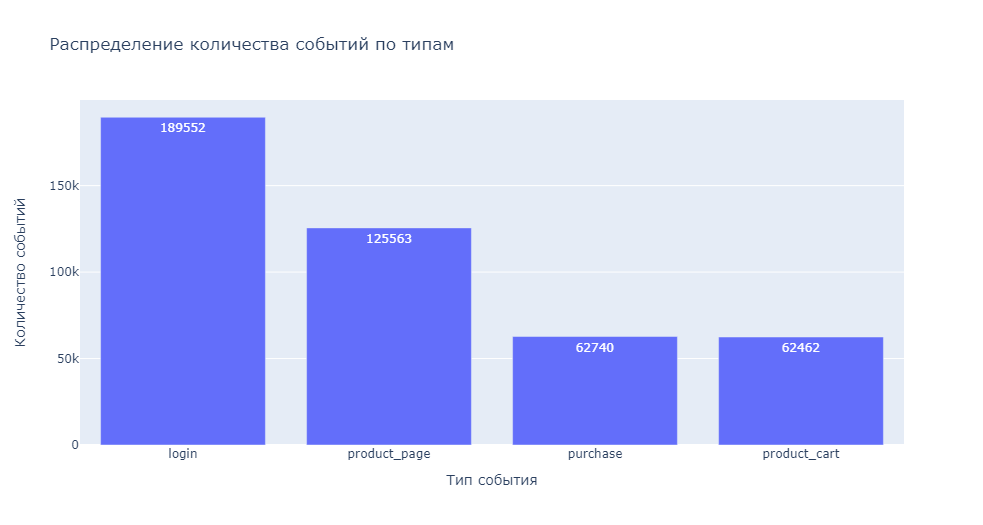

В таблице представлены данные о событиях 4 видов:
- `login` (вход в систему)
- `product_page` (просмотр карточки товара)
- `purchase` (покупка)
- `product_cart` (просмотр корзины)

Наиболее часто совершаемое действие - вход в систему. Обратим также внимание на то, что покупок совершается больше, чем просмотров корзины - вероятно, в интернет-магазине предусмотрена возможность совершения быстрых покупок без посещения корзины.

In [29]:
# изучаем уникальные значения в столбце details
events['details'].unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

In [30]:
fig = px.bar(events.groupby('details').agg({'user_id':'count'}).reset_index().sort_values(by='details', ascending=False), x='details', y='user_id', labels={'user_id':'Количество платежей', 'details':'Сумма платежа'}, title='Распределение количества платежей в зависимости от суммы')
fig.show()

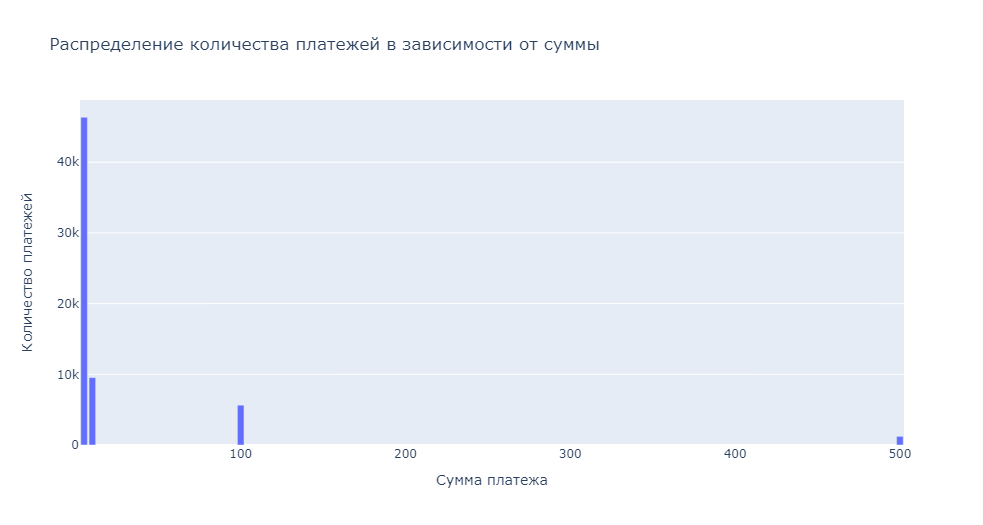

Стоимость покупок в интернет-магазине фиксированная: 4,99, 9,99, 99,99 и 499,99 долларов. Чаще всего покупки совершаются на сумму 4,99 долларов.

### Таблица `participants`

#### Общая информация о таблице

In [31]:
df_info(participants)

            user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  482F14783456D21B     B  recommender_system_test 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None 

Полных дубликатов в таблице: 0
Пропусков в таблице: 0


In [32]:
print('Количество уникальных пользователей в таблице:', participants['user_id'].nunique())

Количество уникальных пользователей в таблице: 16666


**Выводы по таблице**

- таблица содержит данные о 18268 участниках A/B-тестов
- уникальных пользователей в таблице 16666:
    - необходимо проверить пересечение с конкурирующими тестами, а также выяснить, не попали ли одни и те же пользователи в обе группы теста
- пропусков и полных дубликатов нет
- требуется изучить распределение данных в столбце `ab_test`

#### Изучение распределения данных

In [33]:
fig = px.bar(participants.groupby('ab_test').agg({'user_id':'count'}).reset_index().sort_values(by='user_id', ascending=False), x='ab_test', y='user_id', text='user_id', labels={'user_id':'Количество пользователей', 'ab_test':'Название теста'}, title='Распределение пользователей по тестам')
fig.show()

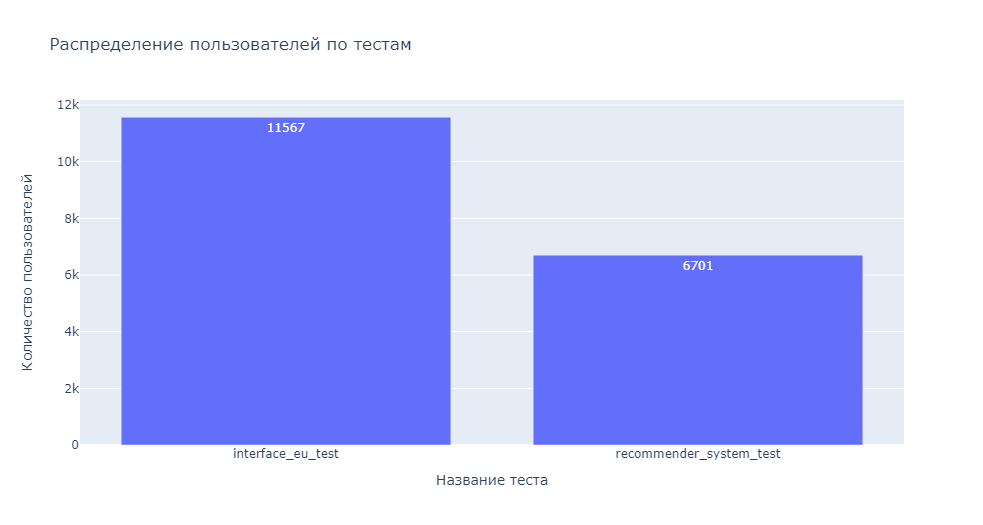

Таблица содержит данные об участниках двух A/B-тестов:
- recommender_system_test (целевой) - 6701 участник
- interface_eu_test (конкурирующий) - 11567 участников

Конкурирующий тест проводится в том же регионе, что и целевой, поэтому может оказать влияние на его результаты. Необходимо будет изучить пересечение участников и принять решение о том, удалять или нет пользователей, попавших в оба теста одновременно.

### Преобразование типов данных

In [34]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'], dayfirst=True)
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'], dayfirst=True)

new_users['first_date'] = pd.to_datetime(new_users['first_date'], dayfirst=True).dt.date

events['event_dt'] = pd.to_datetime(events['event_dt'], dayfirst=True)
events['event_date'] = pd.to_datetime(events['event_dt']).dt.date # создаем отдельный столбец с датой без указания времени

### Результаты ознакомления и предобработки данных

**Таблица `marketing_events`**:
- создан отдельный столбец с признаком проведения кампании в целевом регионе (EU)
- выполнено приведение данных в столбцах `start_dt` и `finish_dt` к типу `datetime`

**Таблица `new_users`**:
- выполнено приведение данных в столбце `first_date` к типу `datetime`

**Таблица `events`**:
- выполнено приведение данных в столбце `event_date` к типу `datetime`
- изучены дубликаты в столбце `event_date`
- изучены пропуси в столбце `details`

**Выявленные проблемы**
- временные рамки теста не совпадают с временными рамками данных в таблицах:
    - таблица `new_users`: данные за период с 07.12.2020 по 23.12.2020
    - таблица `events`: данные за период с 07.12.2020 по 30.12.2020
- количество уникальных пользователей меньше, чем общее количество участников двух параллельных A/B-тестов - есть пересечения пользователей

Таким образом, перед проведением оценки результатов A/B-теста необходимо оценить корректность его проведения.

## Оценка корректности проведения теста

### Выделение участников целевого теста

In [35]:
rst_participants = participants.query('ab_test == "recommender_system_test"').merge(new_users, on='user_id', how='left')
print(f"В тесте приняло участие {len(rst_participants)} человек.")

В тесте приняло участие 6701 человек.


### Проверка соответствия периода регистрации техническому заданию

In [36]:
print(f"Самая ранняя дата регистрации: {str(rst_participants['first_date'].min())}.")
print(f"Самая поздняя дата регистрации: {str(rst_participants['first_date'].max())}.")

Самая ранняя дата регистрации: 2020-12-07.
Самая поздняя дата регистрации: 2020-12-21.


Даты регистрации участников теста `recommender_system_test` совпадают с датами, определенными техническим заданием.

Рассмотрим динамику набора пользователей в группы.

In [37]:
fig = px.line(rst_participants.groupby(['first_date','group']).agg({'user_id':'count'}).reset_index(), x='first_date', y='user_id', color='group', labels={'group':'Группа', 'first_date': 'Дата регистрации', 'user_id': ' Количество пользователей'}, title='Динамика регистрации пользователей')
fig.show()

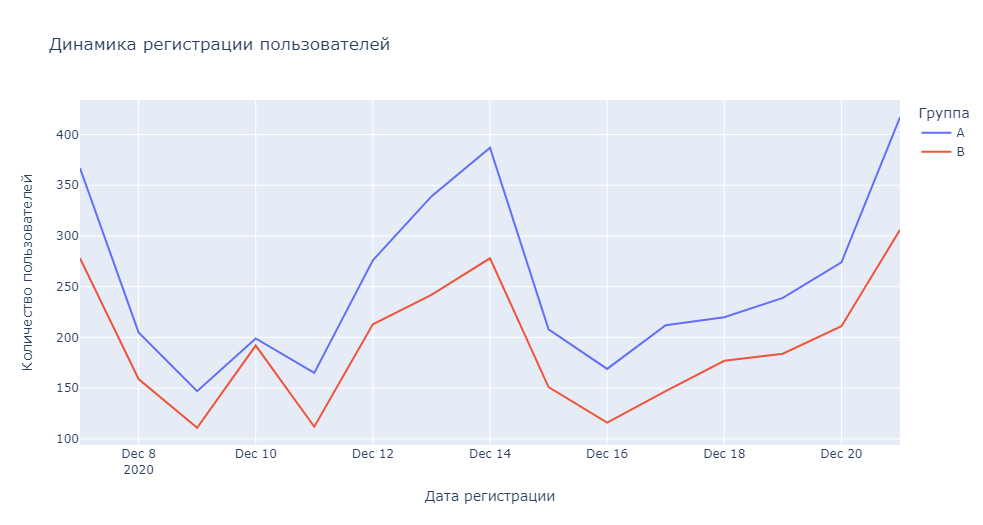

Графики набора пользователей в группы неравномерны, содержат три явных пика с разницей между пиками 7 дней. Динамика набора в разные группы в целом совпадает. Отметим, что в группу А на протяжении всего периода набора попадало больше пользователей, чем в группу В.

#### Недельная цикличность набора в группы

Графики динамики набора пользователей в группы демонстрируют явную недельную цикличность (разница между тремя крупейшими пиками составляет 7 дней). Выделим номер дня недели в отдельный столбец и изучим распределение количества регистраций по дням недели.

In [38]:
rst_participants['weekday'] = pd.to_datetime(rst_participants['first_date']).dt.weekday

fig = px.bar(rst_participants.groupby(['weekday','group']).agg({'user_id':'count'}).reset_index().sort_values(by='user_id', ascending=False), x='weekday', y='user_id', text='user_id', color='group', labels={'user_id': 'Количество пользователей', 'weekday': 'День недели', 'group':'Группа'}, title='Недельная цикличность набора пользователей в группы')
fig.update_layout(xaxis = dict(tickvals = [0, 1, 2, 3, 4, 5, 6], ticktext = ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']))
fig.show()

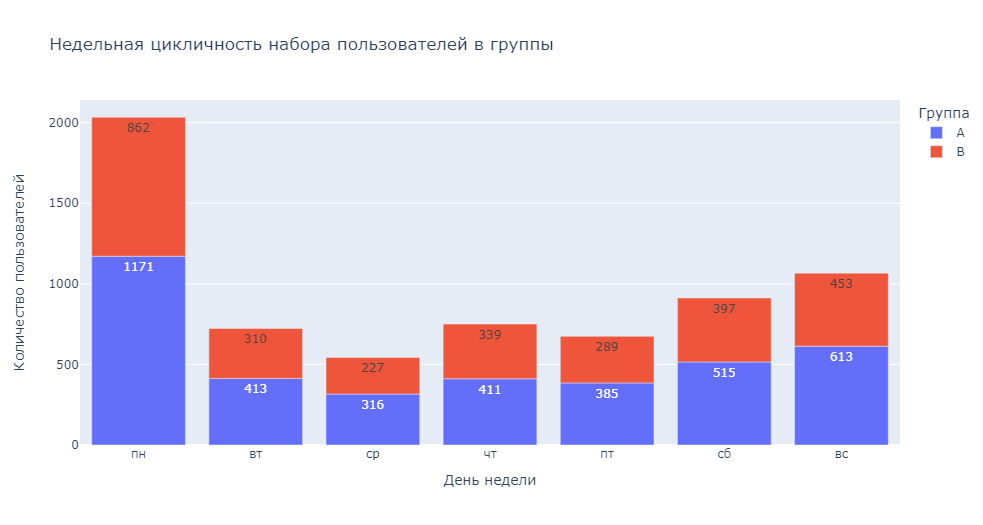

Больше всего пользователей регистрировалось по понедельникам. К середине рабочей недели происходил спад количества регистраций, а к выходным количество начинало возрастать.

### Равномерность распределения пользователей по группам теста

In [39]:
fig = px.bar(rst_participants.groupby('group').agg({'user_id':'count'}).reset_index().sort_values(by='user_id', ascending=False), x='group', y='user_id', text='user_id', labels={'user_id': 'Количество пользователей', 'group': 'Группа'}, title='Распределение пользователей по группам')
fig.show()

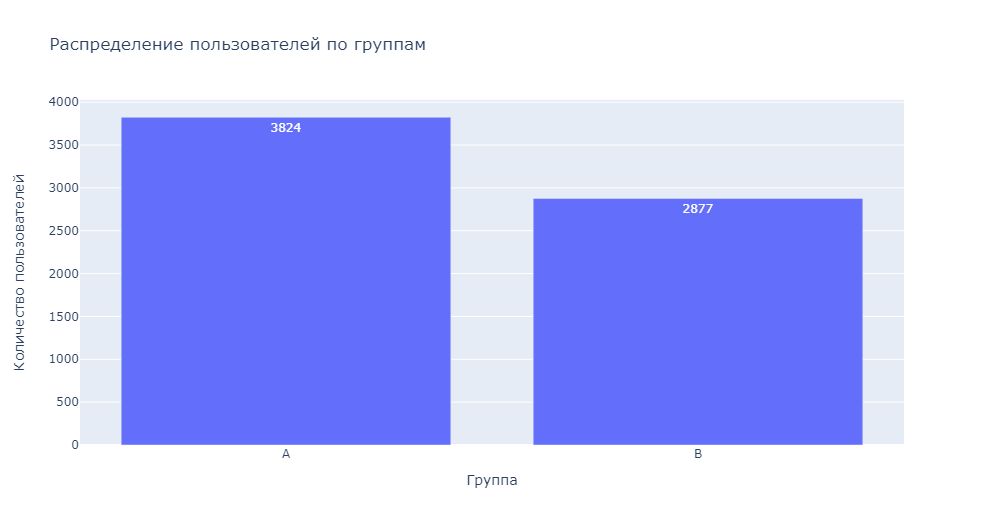

Группы неодинаковы по размеру - в группе А пользователей больше, чем в группе В. Посчитаем относительную разницу между группами.

In [40]:
print(f"Относительная разница между группами А и В составляет {round(100*(len(rst_participants[rst_participants['group'] == 'A']) - (len(rst_participants[rst_participants['group'] == 'B'])))/len(rst_participants[rst_participants['group'] == 'B']))}% от размера группы В.")

Относительная разница между группами А и В составляет 33% от размера группы В.


### Поиск пользователей, участвующих в двух группах теста одновременно

In [41]:
print(f"Количество пользователей, попавших одновременно в обе группы теста: {len(rst_participants.groupby('user_id')['group'].nunique().reset_index().query('group > 1'))}")

Количество пользователей, попавших одновременно в обе группы теста: 0


Пересечений пользователей между группами теста не выявлено.

### Оценка количества и длительности участников теста

Выделим параметры теста и оценим количество участников и продолжительность проведения с помощью онлайн-калькуляторов.

**Базовый уровень конверсии**: 50%

**Ожидаемый эффект**: улучшение каждое метрики не менее, чем на 5 процентных пунктов:
- абсолютный прирост 5%
- относительный прирост 10%

**Длительность теста**: 29 дней (07.12.2020-04.01.2021)

**Количество участников**: 6701 (3824 в группе А и 2877 в группе В)

<!DOCTYPE html>
<html>
<style>
table, th, td {
  border:1px solid black;
}
</style>
<body>

<table style="width:100%">
  <tr>
    <th>№</th>
    <th>Калькулятор</th>
    <th>Уровень достоверности</th>
    <th>Количество участников на выборку</th>
    <th>Продолжительность</th>  
  </tr>
  <tr>
    <td>1</td>
    <td><a href="https://mindbox.ru/tools/ab-test-calculator/">Mindbox</a></td>
    <td>95%</td>
    <td>1570</td>
    <td>-</td>  
  </tr>
  <tr>
    <td>2</td>
    <td><a href="https://www.optimizely.com/sample-size-calculator/?conversion=20&effect=5&significance=95#/?conversion=50&effect=10&significance=95">Optimizely</a></td>
    <td>95%</td>
    <td>1000</td>
    <td>-</td>
  </tr>
  <tr>
    <td>3</td>
    <td><a href="https://www.evanmiller.org/ab-testing/sample-size.html">Evanmiller</a></td>
    <td>95%</td>
    <td>1567</td>
    <td>-</td>
  </tr>
  <tr>
    <td>4</td>
    <td><a href="https://vwo.com/tools/ab-test-duration-calculator/">VWO</a></td>
    <td>-</td>
    <td>-</td>
    <td>35 дней</td>
  </tr>    
</table>

</body>
</html>

Количество участников в каждой группе превышает минимально рекомендуемое тремя тестами. Время проведения на 6 дней короче рекомендуемого.

### Регион регистрации

In [42]:
fig = px.bar(rst_participants.groupby('region').agg({'user_id':'count'}).reset_index().sort_values(by='user_id', ascending=False), x='region', y='user_id', text='user_id', labels={'user_id': 'Количество пользователей', 'region': 'Регион'}, title='Распределение пользователей по регионам')
fig.show()

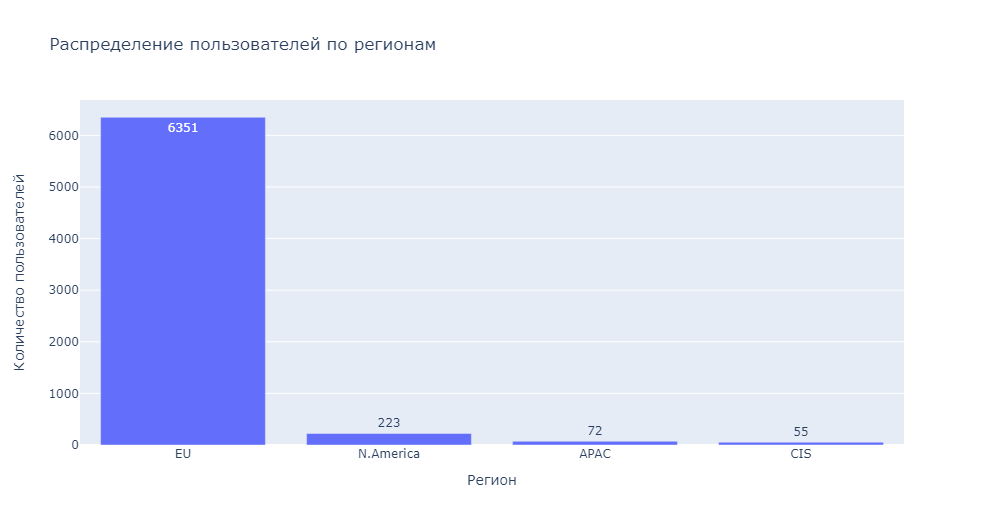

In [43]:
print('Доля пользователей из других регионов от пользователей из целевого региона (%):', round(100*len(rst_participants.query('region != "EU"'))/(len(rst_participants.query('region == "EU"'))),2))

Доля пользователей из других регионов от пользователей из целевого региона (%): 5.51


Среди участников теста есть участники не из целевого региона (5,51% от участников из целевого региона). Изучим их распределение среди групп теста.

In [44]:
# выбираем участников из групп А и В
group_a = rst_participants.query('group == "A"')
group_b = rst_participants.query('group == "B"')

# выделяем среди них участников не из целевого региона
group_a_not_eu = group_a.query('region != "EU"')
group_b_not_eu = group_b.query('region != "EU"')

count = np.array([len(group_a_not_eu), len(group_b_not_eu)])
nobs = np.array([len(group_a), len(group_b)])
    
# задаем уровень статистической значимости
alpha = 0.05

# изучаем соотношение долей
stat, pval = proportions_ztest(count, nobs) 

print('Нулевая гипотеза: между долями нет статистически значимой разницы.')
print('Альтернативная гипотеза: между долями есть статистически значимая разница.\n')

print('p-значение: ', pval)

if pval < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

Нулевая гипотеза: между долями нет статистически значимой разницы.
Альтернативная гипотеза: между долями есть статистически значимая разница.

p-значение:  0.2803899103255276
Не получилось отвергнуть нулевую гипотезу.


Тест не выявил статистически значимых различий в долях участников не из целевых регионов между группами А и В. Это значит что такие участники распределены между группами равномерно.

Доля таких участников невысока, а повсеместное использование VPN не позволяет быть полностью уверенным в том, что пользователь физически находится именно в том месте, которое зафиксировала система. Удалять пользователей не из целевого региона не будем. Убедимся только в том, что доля новых участников из региона EU соответствует техническому заданию (не менее 15% от всех новых пользователей, зарегистрировавшихся в период набора участников в группы).

In [45]:
# выделим границы набора участников в группы
mask = ((new_users['first_date'] >= dt.date(2020, 12, 7)) & (new_users['first_date'] <= dt.date(2020, 12, 21)))

In [46]:
print('Доля участников теста из региона EU от общего количества пользователей из региона EU, зарегистрированных в период набора пользователей в тест, составляет', round(100*len(rst_participants.query('region == "EU"'))/len(new_users.loc[mask].query('region == "EU"')),2), '%.')

Доля участников теста из региона EU от общего количества пользователей из региона EU, зарегистрированных в период набора пользователей в тест, составляет 15.0 %.


Доля участников теста из целевого региона соответствует техническому заданию.

### Пересечение с конкурирующим тестом

При одновременном внедрении нескольких изменений невозможно быть уверенным в том, какое именно изменение повлияло на поведение участников целевого теста. Выясним, есть ли среди участников пользователи, попавшие сразу в оба теста, и посчитаем их количество.

In [47]:
print(f"Количество пользователей, принявших участие одновременно в двух тестах: {len(participants.groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test > 1'))} чел.")

Количество пользователей, принявших участие одновременно в двух тестах: 1602 чел.


Такие пользователи есть, и их количество довольно значительно.

In [48]:
# выделяем пользователей, попавших в оба теста
both = participants.query('user_id in @rst_participants.user_id').merge(new_users, on='user_id', how='left')

In [49]:
print(f"Самая ранняя дата регистрации: {str(both['first_date'].min())}.")
print(f"Самая поздняя дата регистрации: {str(both['first_date'].max())}.")

Самая ранняя дата регистрации: 2020-12-07.
Самая поздняя дата регистрации: 2020-12-21.


Даты регистрации таких пользователей совпадают с датами регистрации целевого теста.

Сгруппируем таких пользователей по наименованию теста и группе и посчитаем их количество.

In [50]:
both.groupby(['ab_test', 'group']).agg({'user_id':'count'})

user_id
ab_test                 group         
interface_eu_test       A          819
                        B          783
recommender_system_test A         3824
                        B         2877

Участников конкурирующего теста меньше, чем целевого, но общее их количество достаточно велико.

Составим матрицу пересечения пользователей и оценим влияние изменений на их поведение.

<!DOCTYPE html>
<html>
<style>
table, th, td {
  border:1px solid black;
}
</style>
<body>

<table style="width:100%">
  <tr>
    <td> </td>
    <td>Группа А конкурирующего теста</td>
    <td>Группа В конкурирующего теста</td>  
  </tr>
  <tr>
    <td>Группа А целевого теста</td>
    <td>не видели ни одно изменение</td>
    <td>не видели изменение целевого теста, видели изменение конкурирующего теста</td>
  </tr>
  <tr>
    <td>Группа В целевого теста</td>
    <td>видели изменение целевого теста, не видели изменение конкурирующего теста</td>
    <td>видели оба изменения</td>
  </tr>
 
</table>

</body>
</html>

Участники группы А конкурирующего теста либо не видели никаких изменений, либо видели только изменения целевого теста: на их поведение либо не влияет ничего, либо влияют целевые изменения.

Участники группы В конкурирующего теста либо видели только изменения конкурирующего теста (и тогда такие изменения могут повлиять на их поведение), либо видели оба изменения (отделить один эффект от другого невозможно).

Таким образом, поведение участников группы А конкурирующего теста не отличается от поведения участников теста целевого, а поведение участников группы В конкурирующего теста может исказить результаты целевого теста. Выделим участников группы В конкурирующего теста и удалим их из таблицы.

In [51]:
b_participants = both.query('ab_test == "interface_eu_test" and group == "B"')
rst_participants = rst_participants.query('user_id not in @b_participants.user_id')

Рассмотрим, насколько изменилось распределение участников, динамика их набора в группы и доля участников не из целевого региона после удаления части участников.

In [52]:
fig = px.line(rst_participants.groupby(['first_date','group']).agg({'user_id':'count'}).reset_index(), x='first_date', y='user_id', color='group', labels={'group':'Группа', 'first_date': 'Дата регистрации', 'user_id': ' Количество пользователей'}, title='Динамика регистрации пользователей')
fig.show()

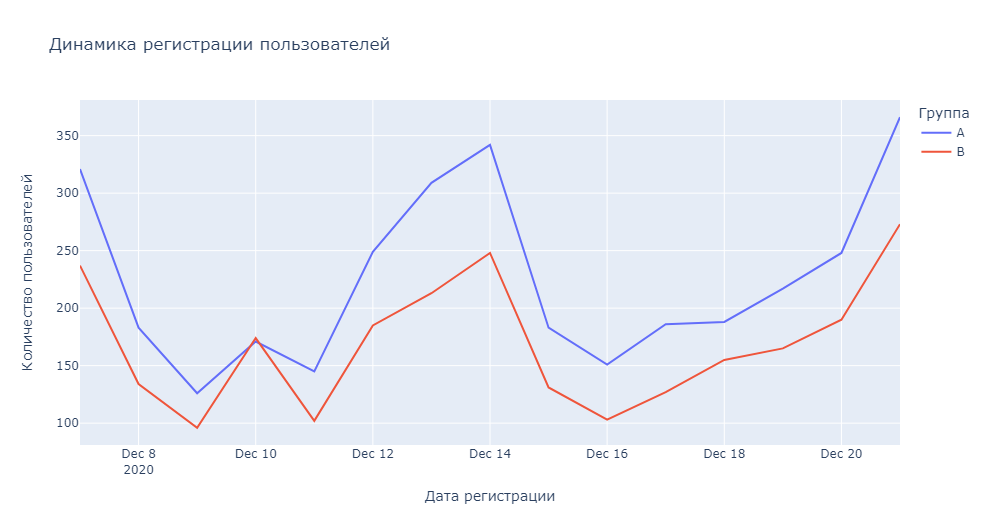

In [53]:
fig = px.bar(rst_participants.groupby('group').agg({'user_id':'count'}).reset_index().sort_values(by='user_id', ascending=False), x='group', y='user_id', text='user_id', labels={'user_id': 'Количество пользователей', 'group': 'Группа'}, title='Распределение пользователей по группам')
fig.show()

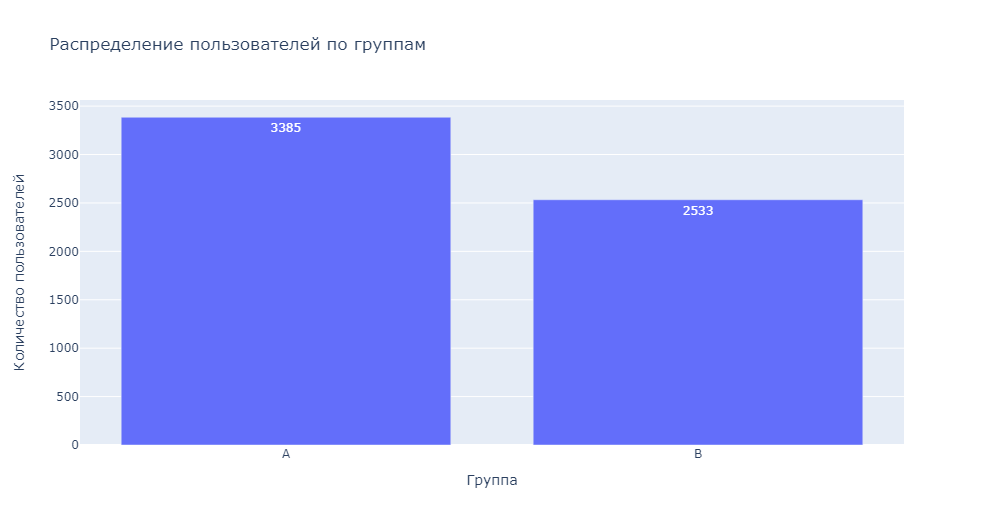

In [54]:
print(f"Относительная разница между группами А и В составляет {round(100*(len(rst_participants[rst_participants['group'] == 'A']) - (len(rst_participants[rst_participants['group'] == 'B'])))/len(rst_participants[rst_participants['group'] == 'B']))}% от размера группы В.\n")
print('Доля участников теста из региона EU от общего количества пользователей из региона EU, зарегистрированных в период набора пользователей в тест, составляет', round(100*len(rst_participants.query('region == "EU"'))/len(new_users.loc[mask].query('region == "EU"')),2), '%.')

Относительная разница между группами А и В составляет 34% от размера группы В.

Доля участников теста из региона EU от общего количества пользователей из региона EU, зарегистрированных в период набора пользователей в тест, составляет 13.15 %.


In [55]:
# выбираем участников из групп А и В
group_a = rst_participants.query('group == "A"')
group_b = rst_participants.query('group == "B"')

# выделяем среди них участников не из целевого региона
group_a_not_eu = group_a.query('region != "EU"')
group_b_not_eu = group_b.query('region != "EU"')

count = np.array([len(group_a_not_eu), len(group_b_not_eu)])
nobs = np.array([len(group_a), len(group_b)])
    
# задаем уровень статистической значимости
alpha = 0.05

# изучаем соотношение долей
stat, pval = proportions_ztest(count, nobs) 

print('Нулевая гипотеза: между долями нет статистически значимой разницы.')
print('Альтернативная гипотеза: между долями есть статистически значимая разница.\n')

print('p-значение: ', pval)

if pval < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

Нулевая гипотеза: между долями нет статистически значимой разницы.
Альтернативная гипотеза: между долями есть статистически значимая разница.

p-значение:  0.2562172317085829
Не получилось отвергнуть нулевую гипотезу.


После удаления части участников:

- динамика регистрации пользователей не изменилась
- общее количество участников уменьшилось: 5918
    - участников в группе А: 3385 
    - участников в группе В: 2533
- относительная разница между группами увеличилась: 34% от количества участников в группе В
- доля участников теста из региона EU от общего количества пользователей из региона EU, зарегистрированных в период набора пользователей в тест, снизилась: 13,15%
- распределение участников не из целевого региона между группами теста не изменилось

### Пересечение периода проведения теста с маркетинговыми кампаниями

Помимо конкурирующего теста на поведение пользователей могли повлиять проводимые одновременно с тестами маркетинговые кампании. Выберем из таблицы с маркетинговыми событиями кампании, соответствующие следующим критериям:
- регион проведения: EU
- период проведения:
    - полностью попадает в период проведения теста
    - начался до теста или одновременно с ним, закончился после начала теста
    - начался после старта теста, закончился вместе с тестом или после него

In [56]:
# обозначим даты начала и завершения теста
test_start = pd.to_datetime(dt.date(2020, 12, 7))
test_finish = pd.to_datetime(dt.date(2021, 1, 4))

In [57]:
marketing_events[(marketing_events['EU'] == 1) & (((marketing_events['start_dt'] <= test_start) & (marketing_events['finish_dt'] > test_start)) | ((marketing_events['start_dt'] >= test_start) & (marketing_events['finish_dt'] >= test_finish)) | ((marketing_events['start_dt'] > test_start) & (marketing_events['finish_dt'] < test_finish)))]

name        regions   start_dt  finish_dt  EU
0  Christmas&New Year Promo  EU, N.America 2020-12-25 2021-01-03   1

Под требуемые условия попадает одна кампания: Christmas&New Year Promo, проводившаяся в Европе и Северной Америке в период с 25.12.2020 по 03.01.2021 года. Кампания началась после остановки набора участников и могла оказать влияние на их дальнейшее поведение.

Отметим также, что сам период проведения теста выбран неудачный: в праздничный сезон регулярность покупок сильно отличается от обычной, что может сильно повлиять на поведение как контрольной группы, так и тестовой.

В следующем разделе изучим пользовательскую активность.

## Изучение пользовательской активности
### Даты совершения событий

In [58]:
print(f"Самая ранняя дата события: {str(events['event_date'].min())}.")
print(f"Самая поздняя дата события: {str(events['event_date'].max())}.")

Самая ранняя дата события: 2020-12-07.
Самая поздняя дата события: 2020-12-30.


Как мы отмечали ранее, данные о событиях неполные: нет данных за период с 31.12.2020 по 04.01.2021. 

Изучим динамику количества имеющихся событий в разрезе групп.

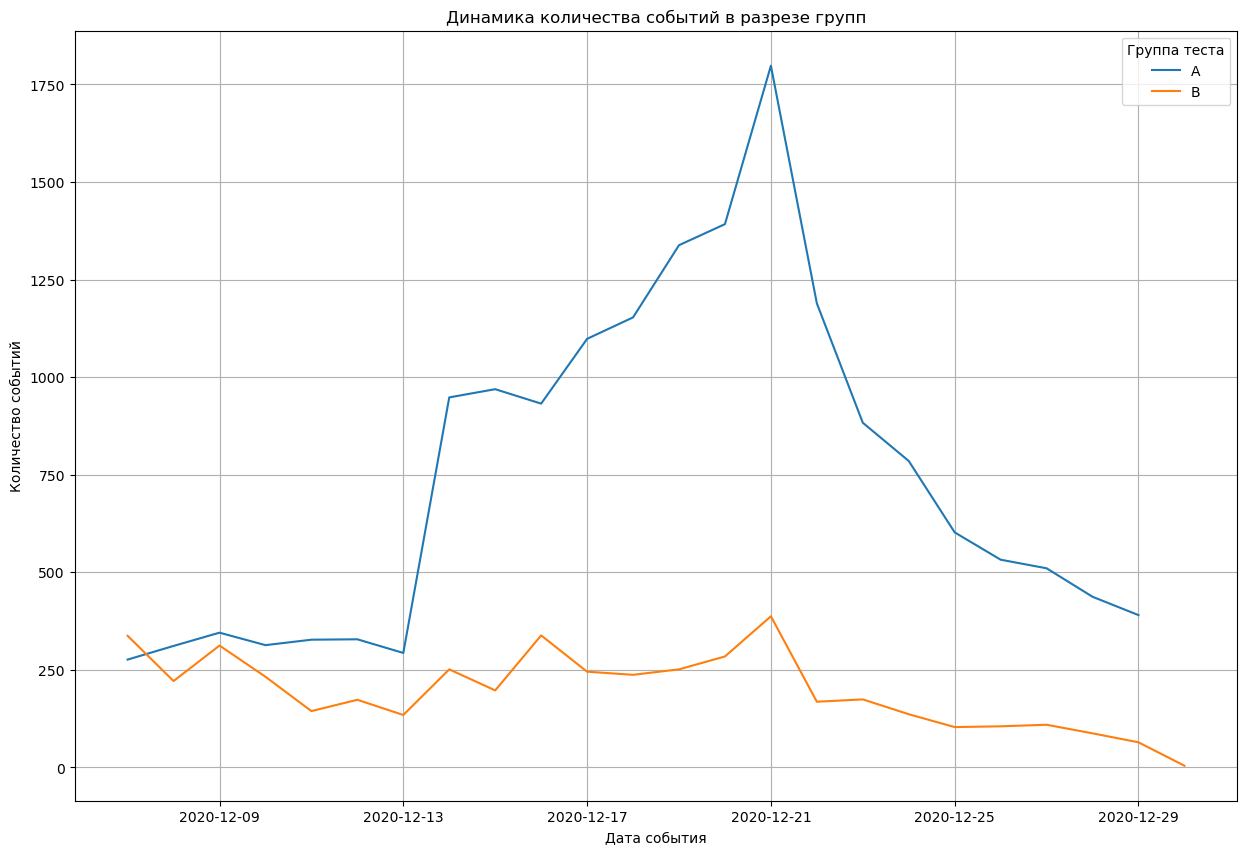

In [59]:
# готовим данные для визуализации
daily_events = events.merge(rst_participants, on='user_id', how='outer').pivot_table(index='event_date', columns='group', values='event_name', aggfunc='count').reset_index()

ax = daily_events[['event_date', 'A']].plot(x='event_date', y='A', figsize=(15,10), grid=True)
daily_events[['event_date', 'B']].plot(x='event_date', y='B', ax=ax, grid=True)
plt.xlabel('Дата события')
plt.ylabel('Количество событий')
plt.title('Динамика количества событий в разрезе групп')
plt.legend(title='Группа теста')
plt.show()

Количество событий в обеих группах изменялось неравномерно. Максимальное количество событий было зарегистрировано в последний день набора пользователей в группы. Данных за 30.12.2020 очень мало, а для группы А за этот день данных нет вообще.

### Активность пользователей

Изучим данные об активности пользователей, ответив на следующие вопросы:

*- Все ли зарегистрированные пользователи прошли авторизацию и совершали переход по продуктовой воронке?*

*- Есть пользователи, которые не совершали событий после регистрации? Сколько их и как они распределены между группами теста?*

*- Нужно ли учитывать пользователей без событий при изучении результатов теста?*

In [60]:
# оставляем только пользователей из теста
events = events.query('user_id in @rst_participants.user_id')

In [61]:
# для каждого пользователя найдем дату совершения первого и последнего события, количество событий и сумму платежей
events_stat = events.groupby('user_id').agg(first_event=('event_date', 'min'),
                              last_event=('event_date', 'max'),
                              total_events=('event_name','count'),
                              purchases=('details','sum')).reset_index()

Изучим распределение общих сумм покупок. Так как попупки совершали далеко не все пользователи, исключим 0 из рассмотрения.

In [62]:
fig = px.box(events_stat.query('purchases > 0'), y='purchases', points='all', labels={'purchases':'Суммарная стоимость покупок'}, title='Диаграмма размаха суммарной стоимости покупок')
fig.show()

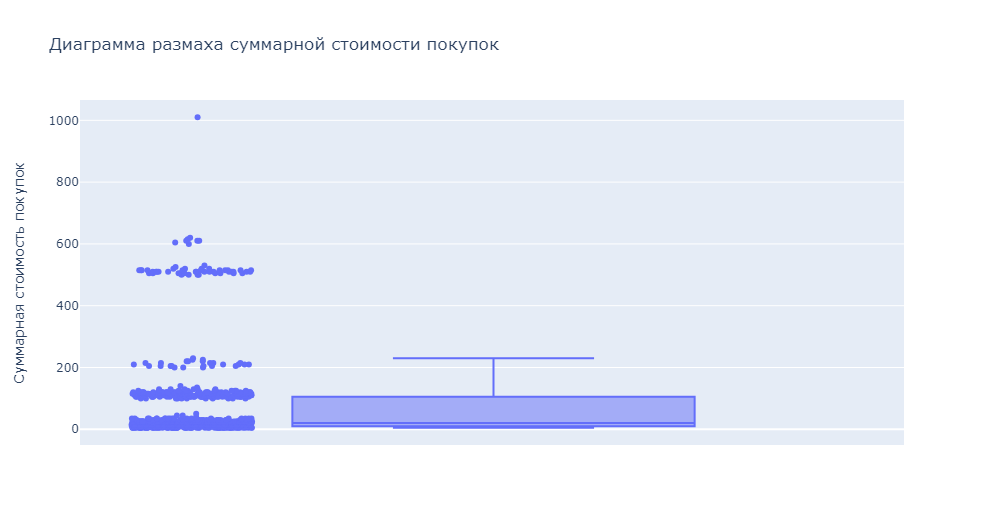

Чаще всего пользователи совершали покупки на общую стоимость от 5 до 50 долларов. Также достаточно большое количество потратили от 100 до 140 долларов. Самый эксцентричный покупатель принес интернет-магазину больше 1000 долларов за рассматриваемый период.

Изучим распределение суммарного количества событий.

In [63]:
fig = px.box(events_stat, y='total_events', labels={'total_events':'Суммарное количество событий'}, title='Диаграмма размаха суммарного количества событий на пользователя')
fig.show()

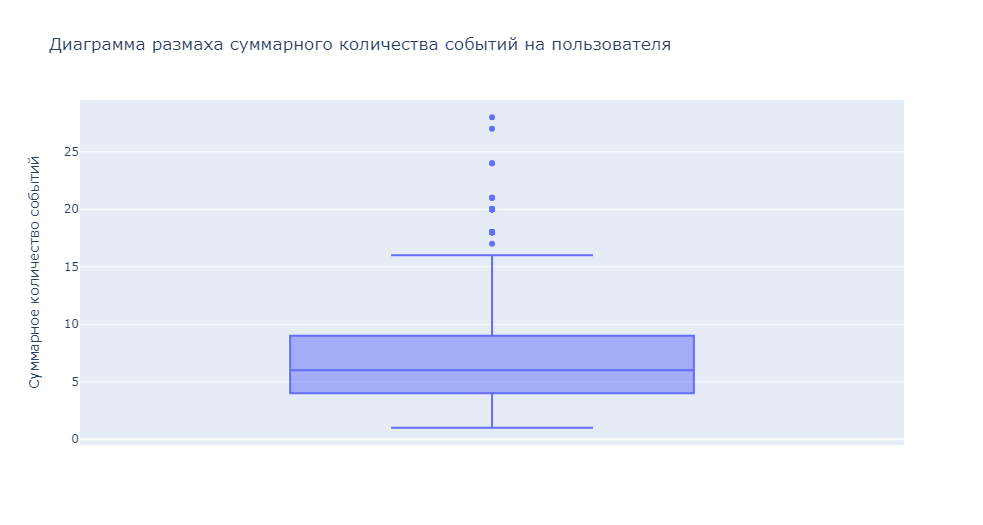

Медианное количество событий на одного пользователя: 6. Самый активный пользователь произвел 28 действий.

#### Все ли пользователи прошли авторизацию?

Для ответа на этот вопрос нам необходимо объединить данные о регистрации с данными о совершенных событиях.

In [64]:
# объединяем данные об участниках теста с агрегированными данными о событиях
rst_events_stat = rst_participants.merge(events_stat, on='user_id', how='left')

Изучим общую информацию о таблице.

In [65]:
rst_events_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5918 entries, 0 to 5917
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       5918 non-null   object 
 1   group         5918 non-null   object 
 2   ab_test       5918 non-null   object 
 3   first_date    5918 non-null   object 
 4   region        5918 non-null   object 
 5   device        5918 non-null   object 
 6   weekday       5918 non-null   int64  
 7   first_event   3244 non-null   object 
 8   last_event    3244 non-null   object 
 9   total_events  3244 non-null   float64
 10  purchases     3244 non-null   float64
dtypes: float64(2), int64(1), object(8)
memory usage: 554.8+ KB


Значения в столбцах `first_event`, `last_event`, `total_events`, `purchases` есть у 3244 пользователей из 5918 участников теста. Данных о событиях, совершенных остальными пользователями после регистрации, отсутствуют.

Посчитаем количество и долю таких пользователей.

In [66]:
print(f"Переход по продуктовой воронке совершили {round(100*len(events_stat)/len(rst_events_stat))}% зарегистрированных пользователей.")
print(f"Действия после регистрации не совершали {len(rst_events_stat) - len(events_stat)} пользователей.")

Переход по продуктовой воронке совершили 55% зарегистрированных пользователей.
Действия после регистрации не совершали 2674 пользователей.


45% пользователей не совершали события после регистрации. Изучим, как они распределены между группами теста.

In [67]:
# выбираем участников из групп А и В
group_a = rst_events_stat.query('group == "A"')
group_b = rst_events_stat.query('group == "B"')

# выбираем среди них участников, которые не совершали действия после регистрации
group_a_no_funnel = group_a[group_a['first_event'].isna()]
group_b_no_funnel = group_b[group_b['first_event'].isna()]

count = np.array([len(group_a_no_funnel), len(group_b_no_funnel)])
nobs = np.array([len(group_a), len(group_b)])
    
# задаем уровень статистической значимости
alpha = 0.05
    
stat, pval = proportions_ztest(count, nobs) 

print('Нулевая гипотеза: между долями нет статистически значимой разницы.')
print('Альтернативная гипотеза: между долями есть статистически значимая разница.\n')

print('p-значение: ', pval)

if pval < alpha:
    print('Отвергаем нулевую гипотезу.\n')
else:
    print('Не получилось отвергнуть нулевую гипотезу.\n')
    
print(f"Доля зарегистрировавшихся участников, не прошедших по продуктовой воронке, в группе А: {round(100*len(group_a_no_funnel)/len(group_a))}%")
print(f"Доля зарегистрировавшихся участников, не прошедших по продуктовой воронке, в группе B: {round(100*len(group_b_no_funnel)/len(group_b))}%")

Нулевая гипотеза: между долями нет статистически значимой разницы.
Альтернативная гипотеза: между долями есть статистически значимая разница.

p-значение:  1.7341522914117508e-196
Отвергаем нулевую гипотезу.

Доля зарегистрировавшихся участников, не прошедших по продуктовой воронке, в группе А: 28%
Доля зарегистрировавшихся участников, не прошедших по продуктовой воронке, в группе B: 68%


Разница между долями есть, и она значительна: в группе А после регистрации не совершали действия 28% пользователей, а в группе В - 68%.

Используя имеющиеся данные, попробуем определить причину такого большого количества оттока. Объединим таблицу с событиями с таблицей с данными пользователей.

In [68]:
rst_events = rst_participants.merge(events, on='user_id', how='outer')

Мы располагаем данными о дате и времени регистрации и устройстве, с которого совершалась регистрация. Попробуем выяснить, нет ли зависимости между отсутствием авторизации после регистрации и какого-либо из этих параметров.

Создадим столбец `just_registration` с признаком 0 для пользователей, которые как минимум авторизовались на сайте, и 1 для тех пользователей, которые не совершали никаких действий после регистрации.

In [69]:
rst_events['just_registration'] = rst_events['event_name'].apply(lambda x: 0 if x in ['purchase', 'product_cart', 'product_page', 'login'] else 1)

#### Отсутствие авторизации и устройство

Сгруппируем данные по устройству, посчитаем общее количество пользователей каждого типа устройста, количество и долю пользователей, не прошедших дальше регистрации.

In [70]:
users_by_device = rst_events.groupby('device').agg({'just_registration':'sum', 'user_id':'nunique'})
users_by_device['rate_to_device_users'] = round(100*users_by_device['just_registration'] / users_by_device['user_id'], 2)
users_by_device.sort_values('rate_to_device_users', ascending=False)

just_registration  user_id  rate_to_device_users
device                                                   
Android               1212     2656                 45.63
iPhone                 558     1233                 45.26
Mac                    239      534                 44.76
PC                     665     1495                 44.48

Среди пользователей устройств Android доля неавторизовавшихся пользователей чуть выше, чем среди пользователей устройств других типов, но разница весьма незначительна. Вероятнее всего, с типом устройств эта ситуцация не связана.

Добавим в группировку группу теста.

In [71]:
users_by_device = rst_events.groupby(['device', 'group']).agg({'just_registration':'sum', 'user_id':'nunique'}).reset_index()
users_by_device['rate_to_device_users'] = round(100*users_by_device['just_registration'] / users_by_device['user_id'], 2)

In [72]:
fig = px.bar(users_by_device, x='device', y='rate_to_device_users', text='rate_to_device_users', color='group', labels={'rate_to_device_users': 'Доля пользователей без авторизации', 'device': 'Устройство', 'group':'Группа'}, title='Доля пользователей, не совершавших действия на сайте после регистрации')
fig.show()

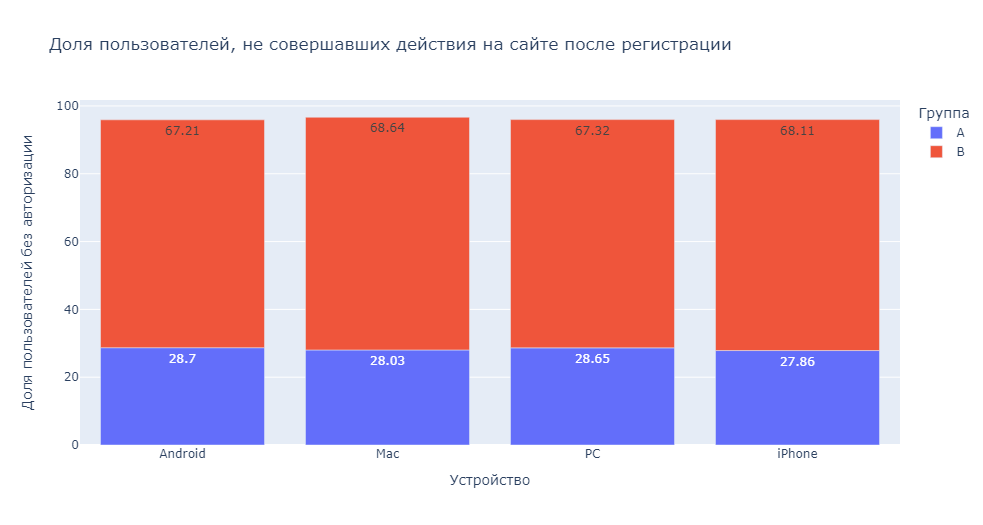

Доля неавторизовавшихся пользователей в группе В выше, но значимых различий между устройствами не обнаружено.

#### Отсутствие авторизации и дата регистрации

Сгруппируем данные по дате регистрации и группе теста и посчитаем долю неавторизовавшихся пользователей за каждый день. 

In [73]:
users_by_reg = rst_events.groupby(['first_date','group']).agg({'just_registration':'sum', 'user_id':'nunique'}).reset_index()
users_by_reg['rate'] = round(100*users_by_reg['just_registration'] / users_by_reg['user_id'], 2)

In [74]:
users_by_reg

first_date group  just_registration  user_id   rate
0   2020-12-07     A                184      321  57.32
1   2020-12-07     B                 78      237  32.91
2   2020-12-08     A                 94      183  51.37
3   2020-12-08     B                 96      134  71.64
4   2020-12-09     A                 56      126  44.44
5   2020-12-09     B                 23       96  23.96
6   2020-12-10     A                114      171  66.67
7   2020-12-10     B                142      174  81.61
8   2020-12-11     A                 63      145  43.45
9   2020-12-11     B                 83      102  81.37
10  2020-12-12     A                192      249  77.11
11  2020-12-12     B                139      185  75.14
12  2020-12-13     A                260      309  84.14
13  2020-12-13     B                199      213  93.43
14  2020-12-14     A                  0      342   0.00
15  2020-12-14     B                181      248  72.98
16  2020-12-15     A                  0      183   0.00
17  2020-12-15     B                104      131  79.39
18  2020-12-16     A                  0      151   0.00
19  2020-12-16     B                 16      103  15.53
20  2020-12-17     A                  0      186   0.00
21  2020-12-17     B                 95      127  74.80
22  2020-12-18     A                  0      188   0.00
23  2020-12-18     B                108      155  69.68
24  2020-12-19     A                  0      217   0.00
25  2020-12-19     B                127      165  76.97
26  2020-12-20     A                  0      248   0.00
27  2020-12-20     B                134      190  70.53
28  2020-12-21     A                  0      366   0.00
29  2020-12-21     B                186      273  68.13

In [75]:
fig = px.bar(users_by_reg, x='first_date', y='just_registration', text='rate', color='group', labels={'rate':'Доля неавторизовавшихся пользователей', 'group':'Группа', 'just_registration': 'Количество пользователей без авторизации', 'first_date': 'Дата регистрации'}, title='Доля пользователей, не совершавших действия на сайте после регистрации')
fig.show()

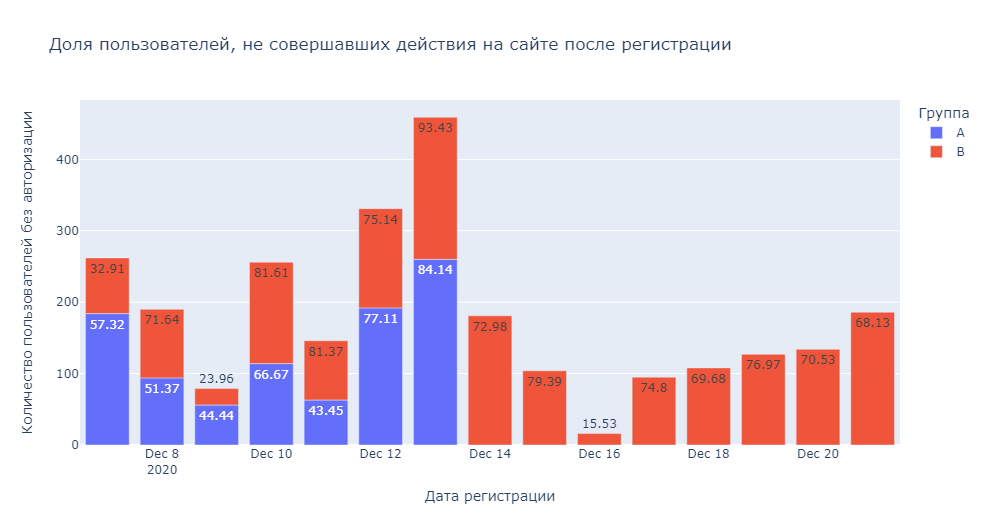

В первую неделю после регистрации неавторизовавшиеся пользователи встречались как в группе А, так и в группе В. С 14 декабря такие пользователи наблюдались только в группе В.

Доля неавторизовавшихся пользователей в разные дни в группе В варьируется от 15,53 до 93,43%. 

Так как ранее мы уже сталкивались с проявлением неполноты данных, наиболее вероятной версией кажется то, что лог событий содержит пропуски за весь рассматриваемый период, а не только за период с 30.12.2020 по 04.01.2021. Косвенно об этом может свидетельствовать и отмеченная динамика количества событий (резкое увеличение количества событий в группе А 14.12.2020, резкий спад после пика 21.12.2020).

В дальнейшем анализе мы можем поступить двумя способами:
- исключить пользователей, не осуществлявших вход на сайт, из рассмотрения, так как ни один их них не дошел до первого действия на сайте
- рассмотреть регистрацию как первый шаг воронки событий и рассчитать конверсию с ее учетом.

Согласно техническому анализу, улучшение метрик ожидается на трех этапах: просмотр карточек товара, просмотр корзины, покупки. Если мы включим регистрацию в рассмотрение, она значительно ухудшит показатели. С другой стороны, если наше предположение о неполноте данных не верно, отсутствие желания у большого количества пользователей воспользоваться услугами интернет-магазина после регистрации также может быть значимым сигналом. 

В дальнейшем при анализе будет рассматривать данные как по всем пользователям, так и  только по тем пользователям, которые как минимум осуществили вход на сайт. Удалять пользователей, не прошедших авторизацию, не будем.

### Горизонт анализа

*- Рассчитайте лайфтайм совершения события пользователем после регистрации, оставьте только те события, которые были совершены в первые 14 дней с момента регистрации*

*- Проверьте, что все участники теста имели возможность совершать события все 14 дней с момента регистрации, оцените когда
пользователи совершают свои первые события каждого вида*

Для каждого события в объединенной таблице `rst_events` рассчитаем лайфтайм - разницу в днях между датой совершения события и датой регистрации.

In [76]:
# рассчитываем лайфтайм для каждого события
rst_events['event_lifetime'] = (rst_events['event_date'] - rst_events['first_date']).dt.days

# удалим из таблицы события с лайфтаймом больше 14 дней; данные по неавторизовавшимся пользователям сохраняем
rst_events = rst_events.query('event_lifetime < 14 or event_lifetime != event_lifetime')

Изучим динамику совершения событий каждого типа.

In [77]:
fig = px.line(rst_events.groupby(['event_date','event_name']).agg({'user_id':'nunique'}).reset_index(), x='event_date', y='user_id', color='event_name', labels={'event_name':'Тип события', 'event_date': 'Дата события', 'user_id': ' Количество пользователей'}, title='Динамика совершения событий пользователями')
fig.show()

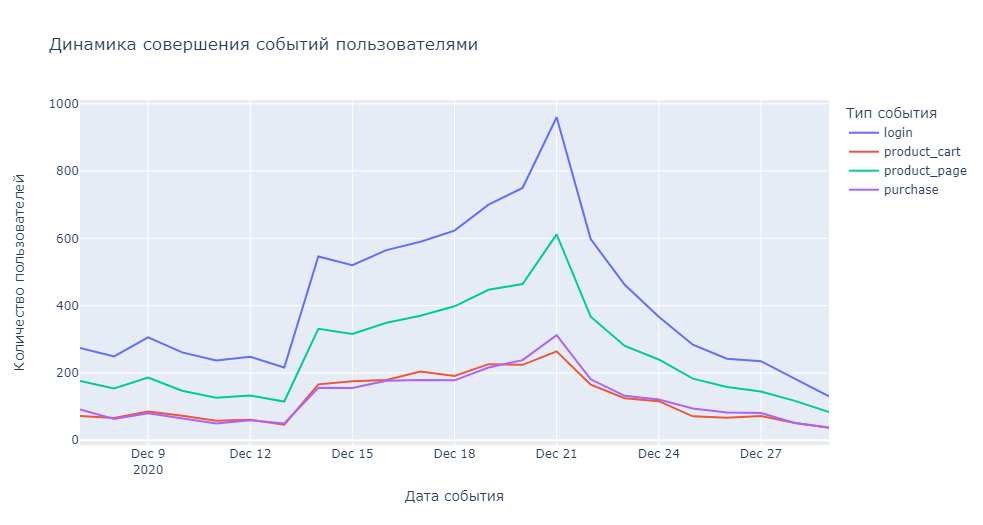

События всех 4 типов совершались ежедневно с примерно равной динамикой, что свидетельствует об отсутствии каких-то технических проблем со стороны интернет-магазина. Таким образом, вероятнее всего, все пользователи имели возможность совершать все действия в течение рассматриваемого периода.

Сгруппируем данные по лайфтайму и изучим распределение количества событий каждого типа в зависимости от лайфтайма.

In [78]:
fig = px.bar(rst_events.groupby(['event_lifetime','event_name']).agg({'user_id':'nunique'}).reset_index().sort_values('event_lifetime'), height=1000, x='event_lifetime', y='user_id', text='user_id', color='event_name', labels={'user_id': 'Количество пользователей', 'event_lifetime': 'Количество дней между регистрацией и совершением события', 'event_name':'Тип события'}, title='Количество дней, прошедших между регистрацией и совершением первого события в разбивке по типам событий')
fig.show()

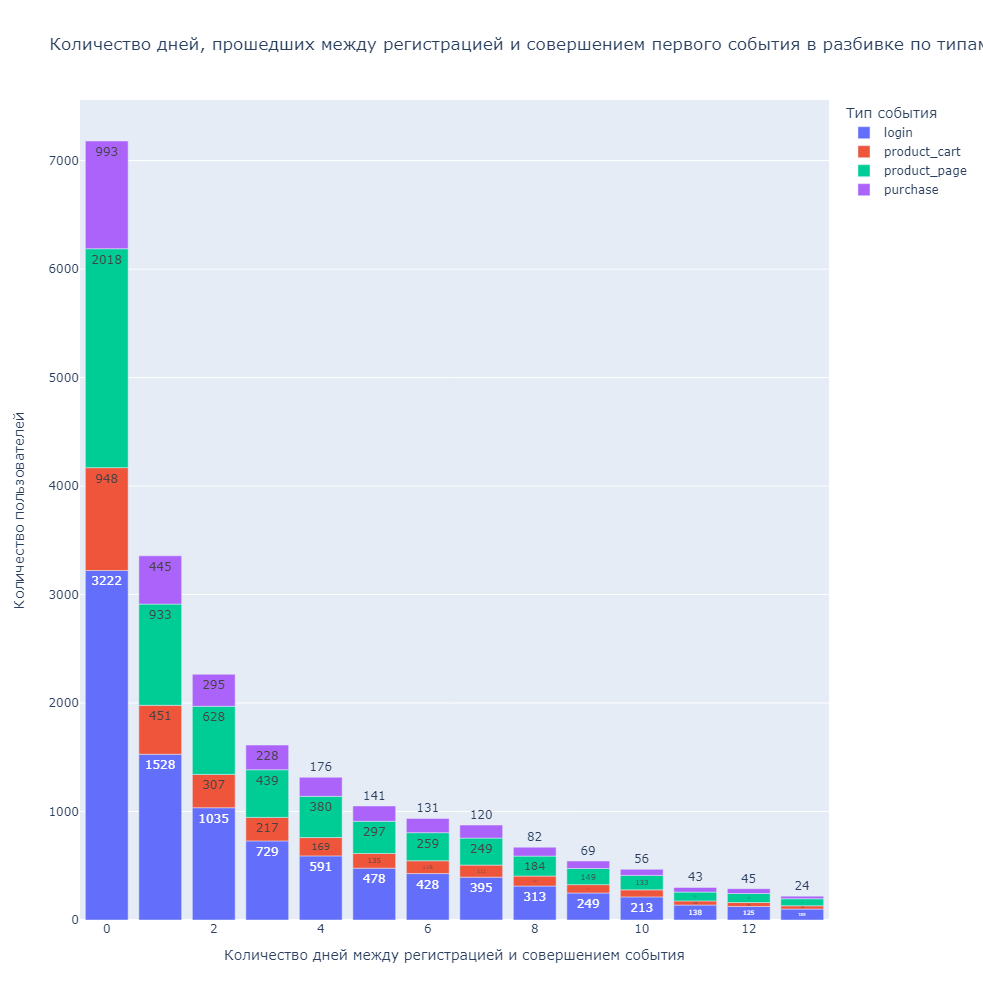

Чаще всего для всех событий встречается лайфтайм 0 дней - события чаще совершались в день регистрации.

Выделим отдельно первые даты совершения каждого события каждым пользователем, рассчитаем, на какой день после регистрации происходило это событие и составим сводную таблицу.

In [79]:
firsts = rst_events.groupby(['user_id','event_name']).agg(event_first_date=('event_date','min')).reset_index().merge(rst_participants[['user_id','first_date']], on='user_id', how='left')
firsts['days_after_registration'] = (firsts['event_first_date'] - firsts['first_date']).dt.days
firsts.groupby(['days_after_registration','event_name']).agg({'user_id':'nunique'})

user_id
days_after_registration event_name           
0                       login            3222
                        product_cart      948
                        product_page     2018
                        purchase          993
1                       login              10
                        product_cart        2
                        product_page        7
                        purchase            5
2                       login               4
                        product_cart        2
                        product_page        2
3                       login               2
                        product_page        1
4                       login               1
5                       login               1
6                       login               2
                        product_cart        1
                        product_page        1
                        purchase            1
8                       login               1
                        product_page        1

Пользователей, которые совершали первые события позже двух дней с момента регистрации - единицы. Самый терпеливый пользователь авторизовался только на 8 день и, похоже, ничего так и не купил.

*Если по каждому из типов событий наши пользователи совершают первые свои события этих типов заметно быстрее, чем за две недели, то может ли нарушение этого условия повлиять на нашу простую воронку, где мы учитываем только количество уникальных пользователей на каждом из шагов?*

Если бы у пользователей не было возможности совершать все действия в течение 14 дней после регистрации, то на совершение повторных действий это повлияло бы сильнее, чем на совершение первых, так как большинство пользователей совершало первые действия в день регистрации. 

## Вывод о соответствии теста требованиям технического задания и возможности получения достоверных результатов A/B-теста

При изучении данных были выявлены следующие проблемы:

1. Данные о событиях, совершенных пользователями, предоставлены не полные. Не хватает данных за период с 31.12.2020 по 04.01.2021, есть сомнения в полноте данных за предыдущие периоды.

2. 1602 пользователя принимали участие в параллельном A/B-тесте. Участников группы В конкурирующего теста из них: 783 человека (удалены, так как их присутствие может исказить результаты теста сильнее всего).

3. Группы теста не одинаковы по количеству (3824 в группе А и 2877 в группе В до удаления участников конкурирующего теста, 3385 в группе А и 2533 в группе В после удаления участников конкурирующего теста).

4. В участники теста попали пользователи не из целевого региона (5,51% от участников из целевого региона). Такие участники равномерно распределены между группами теста. Доля участников из целевого региона от общего количества зарегистрировавшихся в период набора участников: 15% до удаления участников конкурирующего теста, 13,15% после удаления участников конкурирующего теста.

5. Период проведения теста пересекается с проведением маркетинговой кампании Christmas&New Year Promo.

6. Период проведения теста совпадает с праздничным сезоном, когда покупательская активность отличается от привычной.

7. Время проведения теста на 6 дней короче минимально рекомендуемого калькуляторами длительности (рекомендуется 35 дней). Кочество участников в группах при этом больше минимально рекомендуемого (рекомендуется от 1000 до 1600 участников в каждой группе).

Выявленные проблемы свидетельствуют о том, что A/B-тест проводился с нарушениями, что снижает достоверность его результатов.

## Исследовательский анализ

### Распределение количества событий на пользователя в разрезе групп теста

In [80]:
# группируем пользователей по идентификатору и группе, считаем для каждого пользователями количество событий
fig = px.histogram(rst_events.groupby(['user_id','group']).agg({'event_name':'count'}).reset_index(),
                   x='event_name',
                   height=800, 
                   color='group',
                   barmode ='overlay', nbins=29,
                   labels={'event_name':'Количество действий на пользователя', 'group':'Группа'},
                   title='Распределение количества событий на пользователя в разрезе групп').update_layout(yaxis_title='Количество пользователей')
fig.show()

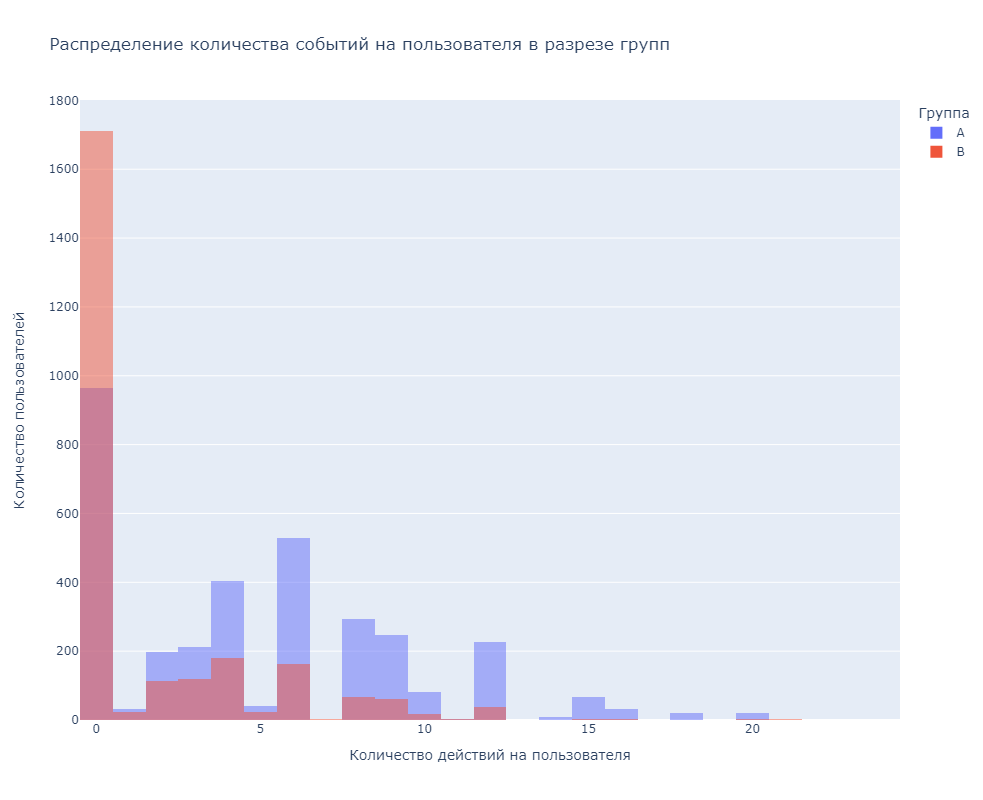

Высокая частота значения 0 объясняется ранее установленным фактом: 45% пользователей не авторизовались на сайте и не совершали никаких других действий после регистрации.

Без учета этих пользователей значения следующие: в группе А чаще всего встречается значение 6 действий на пользователя, в группе В - 4 действия.

In [81]:
print('Среднее количество событий на пользователя в группе А:', round(rst_events.query('group == "A"')['event_name'].count() / rst_events.query('group == "A"')['user_id'].nunique(), 2))
print('Среднее количество событий на пользователя в группе B:', round(rst_events.query('group == "B"')['event_name'].count() / rst_events.query('group == "B"')['user_id'].nunique(), 2), '\n')
print('Среднее количество событий на пользователя в группе A без учета пользователей, не совершавших действия после регистрации:', round(rst_events.query('group == "A"')['event_name'].count() / rst_events[(~rst_events['event_name'].isna()) & (rst_events['group'] == "A")]['user_id'].nunique(), 2))
print('Среднее количество событий на пользователя в группе B без учета пользователей, не совершавших действия после регистрации:', round(rst_events.query('group == "B"')['event_name'].count() / rst_events[(~rst_events['event_name'].isna()) & (rst_events['group'] == "B")]['user_id'].nunique(), 2))

Среднее количество событий на пользователя в группе А: 4.93
Среднее количество событий на пользователя в группе B: 1.73 

Среднее количество событий на пользователя в группе A без учета пользователей, не совершавших действия после регистрации: 6.89
Среднее количество событий на пользователя в группе B без учета пользователей, не совершавших действия после регистрации: 5.34


### Динамика количества событий в группах теста по дням

Изучим распределение числа событий по дням и сравним динамику групп теста между собой.

In [82]:
fig = px.line(rst_events.groupby(['event_date','group']).agg({'event_name':'count'}).reset_index().sort_values(by='event_date'), x='event_date', y='event_name', color='group', labels={'event_date':'Дата события', 'event_name': 'Количество событий', 'group': 'Группа'}, title='Динамика количества событий в группах теста по дням')
fig.add_vrect(x0='2020-12-25',
              x1='2021-1-3',
              fillcolor='green',
              opacity=0.25,
              line_width=0,
              annotation_text='Christmas&New Year Promo',
              annotation_position="top left")
fig.show()

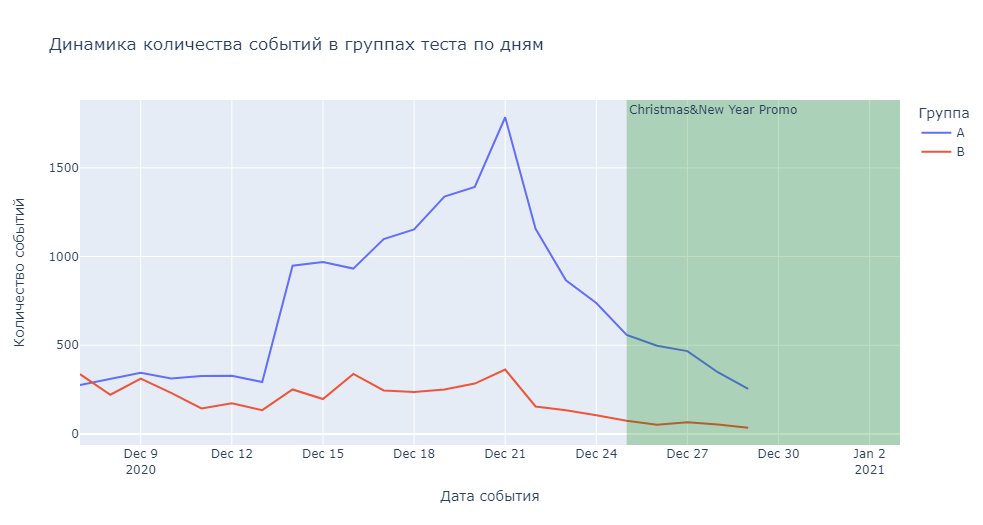

Динамика количества событий в двух группах заметно отличается. В группе В график более равномерный без ярко выраженных пиков и резких спадов. В группе А произошел резкий рост количества событий 14 декабря, пик пришелся на 21 декабря, далее пошел достаточно резкий спад.

В целом мы видим, что действий в группе В совершалось значительно меньше, чем в группе А. Объясняется это как меньшей численностью группы, так и меньшим средним количеством действий на одного пользователя.

Зеленым цветом на графике выделены сроки проведения рекламной кампании Christmas&New Year Promo. По всей видимости, большого влияния на действия пользователей она не оказала.

## Воронка событий

В таблице представлены данные о 4 типах событий, которые выстраиваются в следующую последовательность: вход на сайт -> просмотр карточки товара -> просмотр корзины -> оплата.

Как мы отмечали ранее, покупок совершалось больше, чем просмотров корзины. Просмотр корзины, таким образом, не является обязательным этапом воронки, но удалять его из анализа мы не будем, так как улучшение конверсии по этой метрике также является ожидаемым эффектом.

Добавим также в воронку количество пользователей, прошедших регистрацию - это действие будет являться широким горлом воронки.

In [83]:
# группируем таблицу по типам действий, считаем количество уникальных пользователей, совершивших действие, в разбивке по группам
funnel = rst_events.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index().rename_axis(None,axis=1)

# в каждой группе считаем количество пользователей, прошедших регистрацию
registration = {'event_name': ['registration'], 'A': [rst_events.query('group == "A"')['user_id'].nunique()], 'B': [rst_events.query('group == "B"')['user_id'].nunique()]}
just_registration = pd.DataFrame(data=registration)

# добавляем данные о количестве регистраций в воронку
funnel = pd.concat([funnel, just_registration], axis=0).reset_index().drop(columns=['index'])

# задаем порядок действий в воронке (регистрация -> вход на сайт -> просмотр карточки товара -> просмотр корзины -> оплата)
funnel['order'] = [1, 3, 2, 4, 0]
funnel = funnel.sort_values('order')

funnel

event_name     A     B  order
4  registration  3385  2533      0
0         login  2422   821      1
2  product_page  1571   459      2
1  product_cart   728   225      3
3      purchase   773   226      4

In [84]:
# строим воронку с разбивкой по группам и событиям

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = funnel['event_name'],
    x = funnel['A'],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    y = funnel['event_name'],
    x = funnel['B'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.update_layout(title='Воронка событий с учетом регистраций')

fig.show()

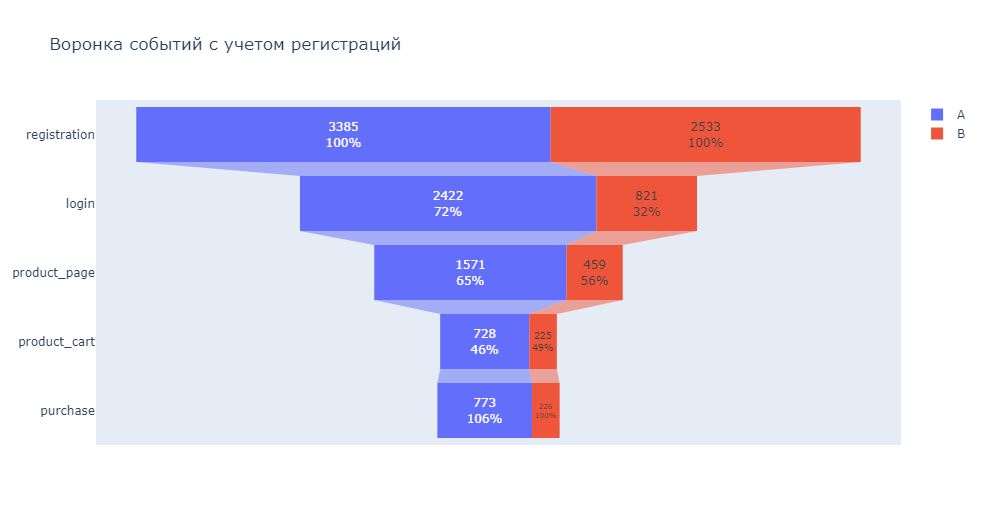

В группе А большая часть пользователей теряется на этапе просмотра карточки товара (46% от предыдущего этапа), а в группе В - на этапе входа на сайт (до этого этапа доходят всего 32% от зарегистрировавшихся пользователей). До этапа покупки в группе А доходят 22,8% от зарегистрировавшихся пользователей, в группе В - 8,9%.

Рассмотрим воронку без учета данных о регистрации.

In [85]:
# строим воронку с разбивкой по группам и событиям

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = funnel.query('event_name != "registration"')['event_name'],
    x = funnel.query('event_name != "registration"')['A'],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    y = funnel.query('event_name != "registration"')['event_name'],
    x = funnel.query('event_name != "registration"')['B'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.update_layout(title='Воронка событий без учета регистраций')

fig.show()

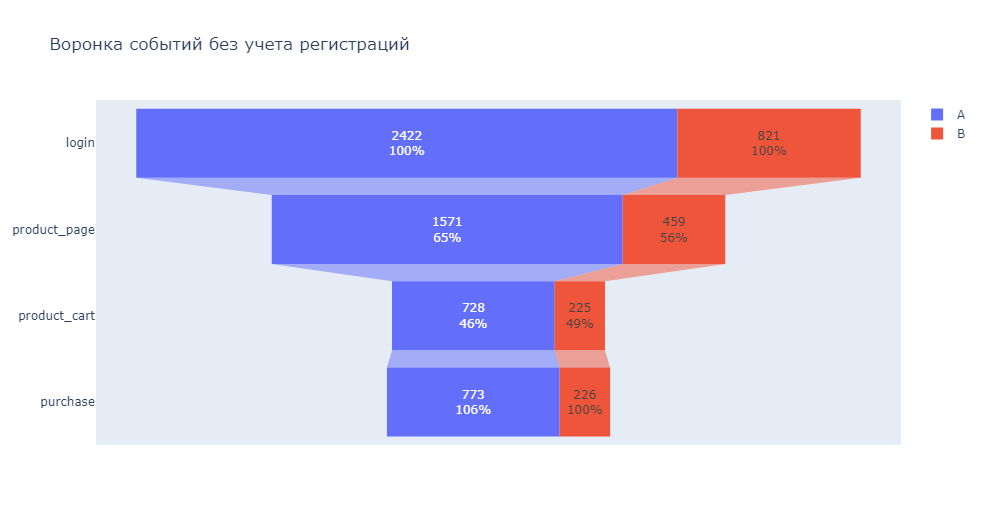

До этапа оплаты товара в группе А доходят 31,9% вошедших на сайт пользователей, а в группе В - 27,5%.

Отметим еще такой факт: если мы сложим количество авторизовавшихся пользователей в группах, мы получим число 3243 - что на 1 меньше, чем количество пользователей, которые совершали события. Один человек сумел пройти по воронке, минуя этап авторизации.

Составим таблицу конверсий по группам. В столбце `rate2prev` укажем долю пользователей, перешедших с предыдущего шага, а в столбце `rate2first` - долю пользователей от первого шага до каждого из последующих. В столбце `rate2first_diff` посчитаем разницу конверсий между группами В и А.

In [86]:
funnel_a = funnel[['event_name', 'A']]
funnel_b = funnel[['event_name', 'B']]

funnel_a['rate2prev'] = round(100*(funnel_a['A'] / funnel_a['A'].shift()).fillna(1), 2)
funnel_a['rate2first'] = 100*funnel_a['A'].apply(lambda x: round(x / funnel_a[funnel_a['event_name'] == 'registration']['A'], 4))

funnel_b['rate2prev'] = round(100*(funnel_b['B'] / funnel_b['B'].shift()).fillna(1), 2)
funnel_b['rate2first'] = 100*funnel_b['B'].apply(lambda x: round(x / funnel_b[funnel_b['event_name'] == 'registration']['B'], 4))

funnel = funnel_a.merge(funnel_b, on='event_name', suffixes=['_a', '_b'])

funnel['rate2first_diff'] = funnel['rate2first_b'] - funnel['rate2first_a']

funnel

event_name     A  rate2prev_a  rate2first_a     B  rate2prev_b  \
0  registration  3385       100.00        100.00  2533       100.00   
1         login  2422        71.55         71.55   821        32.41   
2  product_page  1571        64.86         46.41   459        55.91   
3  product_cart   728        46.34         21.51   225        49.02   
4      purchase   773       106.18         22.84   226       100.44   

   rate2first_b  rate2first_diff  
0        100.00             0.00  
1         32.41           -39.14  
2         18.12           -28.29  
3          8.88           -12.63  
4          8.92           -13.92

Ни на одном из этапов в группе увеличение конверсии не менее, чем на 5 процентных пунктов, не произошло. Напротив, значения уменьшились, и очень сильно - разница с группой А составляет от 12,63 до 39,14 процентных пунктов.

Рассчитаем те же самые значения для воронки без этапа регистрации, чтобы узнать конверсию в просмотры карточек товаров и покупки от количества авторизаций.

In [87]:
funnel_a = funnel.query('event_name != "registration"')[['event_name', 'A']]
funnel_b = funnel.query('event_name != "registration"')[['event_name', 'B']]

funnel_a['rate2prev'] = round(100*(funnel_a['A'] / funnel_a['A'].shift()).fillna(1), 2)
funnel_a['rate2first'] = 100*funnel_a['A'].apply(lambda x: round(x / funnel_a[funnel_a['event_name'] == 'login']['A'], 4))

funnel_b['rate2prev'] = round(100*(funnel_b['B'] / funnel_b['B'].shift()).fillna(1), 2)
funnel_b['rate2first'] = 100*funnel_b['B'].apply(lambda x: round(x / funnel_b[funnel_b['event_name'] == 'login']['B'], 4))

funnel = funnel_a.merge(funnel_b, on='event_name', suffixes=['_a', '_b'])

funnel['rate2first_diff'] = funnel['rate2first_b'] - funnel['rate2first_a']

funnel

event_name     A  rate2prev_a  rate2first_a    B  rate2prev_b  \
0         login  2422       100.00        100.00  821       100.00   
1  product_page  1571        64.86         64.86  459        55.91   
2  product_cart   728        46.34         30.06  225        49.02   
3      purchase   773       106.18         31.92  226       100.44   

   rate2first_b  rate2first_diff  
0        100.00             0.00  
1         55.91            -8.95  
2         27.41            -2.65  
3         27.53            -4.39

Показатели не такие драматичные, но улучшения метрик в группе В так и не произошло - наблюдается снижение от 2,65 до 8,95 процентных пунктов.

## Оценка результатов A/B-тестирования

Для оценки результатов A/B-тестирования сравним доли пользователей, перешедших с первого этапа воронки на каждый последующий, в группах А и В. Оценки равенства долей проводиться с использованием z-критерия. Уровень статистической значимости стандартный - 5%. Так как сравнения будут проводиться множественных для нескольких событий, вводим поправку Бонферрони.

Составим функцию проверки гипотезы.

In [88]:
def z_test(data1, data2, event):
    
    # считаем количество пользователей в каждой группе
    total_users = np.array([data1['user_id'].nunique(), data2['user_id'].nunique()])
    
    # считаем количество пользователей, совершивших событие, в каждой группе
    event_users = np.array([data1[data1['event_name'] == event]['user_id'].nunique(), data2[data2['event_name'] == event]['user_id'].nunique()])
    
    # задаем уровень статистической значимости
    alpha = 0.05
    
    stat, pval = proportions_ztest(event_users, total_users) 
    
    # вводим поправку Бонферрони для 4 сравнений
    bonferroni_alpha = alpha / 4 
    
    print('Гипотеза о равенстве долей проверяется для события', event)
    print('p-значение: ', pval)

    if pval < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница\n')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными\n')

In [89]:
# проверяем гипотезы для всех пользователей, прошедших регистрацию
for event in funnel.query('event_name != "registration"')['event_name'].unique():
    z_test(rst_events.query('group == "A"'), rst_events.query('group == "B"'), event)

Гипотеза о равенстве долей проверяется для события login
p-значение:  7.229117698680228e-197
Отвергаем нулевую гипотезу: между долями есть значимая разница

Гипотеза о равенстве долей проверяется для события product_page
p-значение:  6.569432618762526e-114
Отвергаем нулевую гипотезу: между долями есть значимая разница

Гипотеза о равенстве долей проверяется для события product_cart
p-значение:  4.7039095755160946e-39
Отвергаем нулевую гипотезу: между долями есть значимая разница

Гипотеза о равенстве долей проверяется для события purchase
p-значение:  2.1929876288488273e-45
Отвергаем нулевую гипотезу: между долями есть значимая разница



Во всех 4 случаях тест обнаружил значимую разницу между конверсиями в группах А и В.

Исключим неавторизовавшихся после регистрации пользователей и проверим гипотезы еще раз.

In [90]:
for event in funnel.query('event_name != "registration"')['event_name'].unique():
    z_test(rst_events[(~rst_events['event_name'].isna()) & (rst_events['group'] == "A")], rst_events[(~rst_events['event_name'].isna()) & (rst_events['group'] == "B")], event)

Гипотеза о равенстве долей проверяется для события login
p-значение:  0.08601687380547406
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Гипотеза о равенстве долей проверяется для события product_page
p-значение:  3.841500556603692e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница

Гипотеза о равенстве долей проверяется для события product_cart
p-значение:  0.14412076974264504
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Гипотеза о равенстве долей проверяется для события purchase
p-значение:  0.017649687175216127
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Без учета пользователей, отсеявшихся после этапа регистрации, тест обнаружил следующее:
- на этапах `login`, `product_cart`, `purchase` значимых различий между долями в группах нет
- на этапе `product_page` между долями есть значимая разница

Таким образом, независимо от того, считаем мы регистрацию первым шагом воронки или нет, желаемых показателей достичь не удалось - в лучшем случае тесты не обнаруживают статистическую разницу между конверсиями в группах А и В на 3 из 4 этапов. В худшем случае конверсия на всех шагах в группе В значительно ниже, чем конверсия в группе А.

## Вывод

На основании предоставленных данных был проведен анализ A/B-теста по внедрению новой рекомендательной системы в интернет-магазине.

Техническое задание:
- Название теста: recommender_system_test
- Группы: А (контрольная), B (новая платёжная воронка)
- Дата запуска: 2020-12-07
- Дата остановки набора новых пользователей: 2020-12-21
- Дата остановки: 2021-01-04
- Ожидаемое количество участников теста: 15% новых пользователей из региона EU
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 5 процентных пунктов:
    - конверсии в просмотр карточек товаров — событие product_page
    - просмотры корзины — product_cart
    - покупки — purchase
    
По результатам анализа A/B-теста установлено, что ожидаемый эффект достигнут не был ни по одной метрике. Анализ конверсии проводился с применением двух подходов: только с учетом авторизовавшихся на сайте после регистрации пользователей и без них. Результаты анализа конверсии представлены в таблице:

|   Шаг воронки	|   Изменение конверсии в группе В по сравнению с группой А, % (все участники) |  Изменение конверсии в группе В по сравнению с группой А, % (только авторизовавшиеся) 	|   	
|:---	|:---	|:---	|
|   вход на сайт	|   -39,14	|   -	|   	
|   просмотр карточки товара	|   -28,29	|   -8,95	| 
|   просмотр корзины	|   -12,63	|   -2,65	| 
|   покупка	|   -13,92	|   -4,39	| 

Анализ разницы долей показал, что в лучшем случае тесты не обнаруживают статистическую разницу между конверсиями в группах А и В на этапах `вход на сайт`, `просмотр корзины`, `покупка`. В худшем случае конверсия на всех шагах в группе В значительно ниже, чем конверсия в группе А.

Вместе с этим было обнаружено, что тест проводился с нарушениями:

1. Данные о событиях, совершенных пользователями, предоставлены не полные. Не хватает данных за период с 31.12.2020 по 04.01.2021, есть сомнения в полноте данных за предыдущие периоды.

2. 1602 пользователя принимали участие в параллельном A/B-тесте. Участников группы В конкурирующего теста из них: 783 человека (удалены, так как их присутствие может исказить результаты теста сильнее всего).

3. Группы теста не одинаковы по количеству (3824 в группе А и 2877 в группе В до удаления участников конкурирующего теста, 3385 в группе А и 2533 в группе В после удаления участников конкурирующего теста).

4. В участники теста попали пользователи не из целевого региона (5,51% от участников из целевого региона). Такие участники равномерно распределены между группами теста. Доля участников из целевого региона от общего количества зарегистрировавшихся в период набора участников: 15% до удаления участников конкурирующего теста, 13,15% после удаления участников конкурирующего теста.

5. Период проведения теста пересекается с проведением маркетинговой кампании Christmas&New Year Promo.

6. Период проведения теста совпадает с праздничным сезоном, когда покупательская активность отличается от привычной.

Таким образом, достоверность результатов A/B-теста подлежит сомнению. Рекомендации:
- проверить полноту данных о событиях; в случае предоставления дополнительных данных провести анализ заново
- учесть выявленные нарушения проведения теста и провести A/B-тест заново